In [14]:
from collections import Counter, defaultdict
import pathlib
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from data.russia import Russia
from train import train
from utils.training import TrainConfig

In [2]:
%matplotlib inline

In [33]:
%precision 2
pd.set_option('display.precision', 2)

In [3]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
TIMESTAMPS_PER_MONTH = 10

In [5]:
dumps_path = pathlib.Path("dumps")
if not dumps_path.exists():
    dumps_path.mkdir()

# Plan

## Data

1. Years: 2018–2022.
2. Each year: N fields.
3. Each field:
  - features: time series of 10 Sentinel-2 bands (median value for each field), number of timestamps is different;
  - target: crop class label (13 classes).

## Models

1. Classical ML:
  - Random Forest;
  - Catboost;
  - LightGBM.
2. Deep learning:
  - Transformer;
  - TempCNN;
  - *EarlyRNN*.
 
## Training&evaluation workflow

1. For all models besides EarlyRNN: make datasets of reduced size (1–6 months, where 6 months is full-length time series), train models separately on each of them.
2. For EarlyRNN: train using full-length time series.
3. Compare accuracy, precision, recall, f1-score, kappa.

# Part 0. Dataset statistics

In [7]:
dataset_train = Russia(root="/home/pavel/elects_data/russia/", partition="train", broadcast_y=False)
dataset_test = Russia(root="/home/pavel/elects_data/russia/", partition="test", broadcast_y=False)

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057


In [18]:
crop_classes = pd.read_csv("/home/pavel/elects_data/russia/classmapping.csv")
crop_classes

,class_id,class_code,class_name
0,0,1,Corn
1,1,2,Soy
2,2,3,Sunflower
3,3,4,Potato
4,4,5,Sugarbeet
5,5,6,Winter rape
6,6,7,Spring rape
7,7,8,Rice
8,8,101,Winter cereals
9,9,102,Spring cereals


In [10]:
dataset_train["X"].shape, dataset_test["X"].shape

((8264, 600), (2057, 600))

In [41]:
cnt_train = Counter(dataset_train["y"])
cnt_test = Counter(dataset_test["y"])
crop_classes_counts_train = pd.DataFrame({
    "class_id": cnt_train.keys(),
    "count_train": cnt_train.values(),
    "sum_train": [100 * val / sum(cnt_train.values()) for val in cnt_train.values()]
    
})
crop_classes_counts_test = pd.DataFrame({
    "class_id": cnt_test.keys(),
    "count_test": cnt_test.values(),
    "share_test": [100 * val / sum(cnt_test.values()) for val in cnt_test.values()]
})
crop_classes_count = crop_classes_counts_train.merge(crop_classes_counts_test)
crop_classes_count

,class_id,count_train,sum_train,count_test,share_test
0,8,2379,28.79,594,28.88
1,0,590,7.14,147,7.15
2,9,1442,17.45,360,17.50
3,1,207,2.50,51,2.48
4,12,749,9.06,186,9.04
5,2,635,7.68,158,7.68
6,11,708,8.57,176,8.56
7,10,839,10.15,209,10.16
8,4,182,2.20,45,2.19
9,6,425,5.14,106,5.15


In [42]:
crop_classes_stats = crop_classes.merge(crop_classes_count)
crop_classes_stats.drop(columns=["class_code"], inplace=True)
crop_classes_stats.columns = ["Class label", "Crop name", "# in train", "% in train", "# in test", "% in test"]
crop_classes_stats

,Class label,Crop name,# in train,% in train,# in test,% in test
0,0,Corn,590,7.14,147,7.15
1,1,Soy,207,2.50,51,2.48
2,2,Sunflower,635,7.68,158,7.68
3,3,Potato,68,0.82,16,0.78
4,4,Sugarbeet,182,2.20,45,2.19
5,5,Winter rape,40,0.48,9,0.44
6,6,Spring rape,425,5.14,106,5.15
7,8,Winter cereals,2379,28.79,594,28.88
8,9,Spring cereals,1442,17.45,360,17.50
9,10,Feed,839,10.15,209,10.16


In [52]:
print(crop_classes_stats.to_latex(index=False, caption="Crop classes statistics in dataset", label="Table 2.3.1"))

\begin{table}
\centering
\caption{Crop classes statistics in dataset}
\label{Table 2.3.1}
\begin{tabular}{rlrrrr}
\toprule
 Class label &      Crop name &  \# in train &  \% in train &  \# in test &  \% in test \\
\midrule
           0 &           Corn &         590 &        7.14 &        147 &       7.15 \\
           1 &            Soy &         207 &        2.50 &         51 &       2.48 \\
           2 &      Sunflower &         635 &        7.68 &        158 &       7.68 \\
           3 &         Potato &          68 &        0.82 &         16 &       0.78 \\
           4 &      Sugarbeet &         182 &        2.20 &         45 &       2.19 \\
           5 &    Winter rape &          40 &        0.48 &          9 &       0.44 \\
           6 &    Spring rape &         425 &        5.14 &        106 &       5.15 \\
           8 & Winter cereals &        2379 &       28.79 &        594 &      28.88 \\
           9 & Spring cereals &        1442 &       17.45 &        360 &      17.

/tmp/ipykernel_13454/3613067214.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(crop_classes_stats.to_latex(index=False, caption="Crop classes statistics in dataset", label="Table 2.3.1"))


# Part 1. Training

## Classical Machine Learning

### Random Forest

In [ ]:
rf_hyperparameters = {
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 21),
}

In [1]:
rf_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    rf_train_params = TrainConfig(        
        model="rf",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=rf_hyperparameters,
        n_iter=100
    )
    best_model, stats = train(rf_train_params)
    rf_results[n_months]["best_model"] = best_model
    rf_results[n_months]["stats"] = stats

NameError: name 'defaultdict' is not defined

In [6]:
with open(dumps_path / "rf_results.dump", "wb") as f:
    pickle.dump(rf_results, f)

### LightGBM

In [ ]:
lgbm_hyperparameters = {
    "boosting_type": ("dart",),
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 10),
    "learning_rate": (0.001, 0.01, 0.1, 1),
}

In [5]:
lgbm_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    lgbm_train_params = TrainConfig(
        model="lightgbm",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=lgbm_hyperparameters,
        n_iter=50
    )
    best_model, stats = train(lgbm_train_params)
    lgbm_results[n_months]["best_model"] = best_model
    lgbm_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.422) fscore: (test=0.391) kappa: (test=0.293) precision: (test=0.389) recall: (test=0.422) total time= 1.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.426) fscore: (test=0.410) kappa: (test=0.306) precision: (test=0.404) recall: (test=0.426) total time= 1.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.374) fscore: (test=0.274) kappa: (test=0.161) precision: (test=0.302) recall: (test=0.374) total time= 2.3min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.436) fscore: (test=

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.413) fscore: (test=0.369) kappa: (test=0.279) precision: (test=0.358) recall: (test=0.413) total time= 1.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.420) fscore: (test=0.396) kappa: (test=0.294) precision: (test=0.396) recall: (test=0.420) total time= 1.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.436) fscore: (test=0.400) kappa: (test=0.309) precision: (test=0.408) recall: (test=0.436) total time= 1.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.409) fscore: (test=0.378) kappa: (test=0.281) precision: (test=0.376) recall: (test=0.409) total time=  34.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.446) fscore: (test=0.428) kappa: (test=0.329) precis

X shape: (8264, 200) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.431) fscore: (test=0.413) kappa: (test=0.310) precision: (test=0.408) recall: (test=0.431) total time= 1.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.315) fscore: (test=0.154) kappa: (test=0.004) precision: (test=0.148) recall: (test=0.315) total time=  43.5s
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.321) fscore: (test=0.166) kappa: (test=0.016) precision: (test=0.166) recall: (test=0.321) total time=  41.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.428) fscore: (test=0.407) kappa: (test=0.306) precision: (test=0.402) recall: (test=0.428) total time= 1.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.0

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=50; accuracy: (test=0.316) fscore: (test=0.157) kappa: (test=0.007) precision: (test=0.212) recall: (test=0.316) total time=   5.5s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=50; accuracy: (test=0.331) fscore: (test=0.187) kappa: (test=0.038) precision: (test=0.231) recall: (test=0.331) total time=   5.5s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=8, n_estimators=90; accuracy: (test=0.442) fscore: (test=0.424) kappa: (test=0.323) precision: (test=0.416) recall: (test=0.442) total time=  30.6s
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.424) fscore: (test=0.407) kappa: (test=0.303) precision: (test=0.421) recall: (test=0.424) total time= 3.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.410) fscore: (test=0.377) kappa: (test=0.281) precision: 

Fitting best model on whole train dataset
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.454) fscore: (test=0.442) kappa: (test=0.349) precision: (test=0.449) recall: (test=0.454) total time= 1.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=90; accuracy: (test=0.288) fscore: (test=0.129) kappa: (test=0.000) precision: (test=0.083) recall: (test=0.288) total time=  56.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=180; accuracy: (test=0.488) fscore: (test=0.463) kappa: (test=0.381) precision: (test=0.461) recall: (test=0.488) total time= 2.0min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=7, n_estimators=400; accuracy: (test=0.122) fscore: (test=0.061) kappa: (test=0.015) precision: (test=0.108) recall: (test=0.122) total time= 4.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=8, n_estimators=350; accuracy: (test=0.490) fscore:

[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=70; accuracy: (test=0.467) fscore: (test=0.437) kappa: (test=0.355) precision: (test=0.426) recall: (test=0.467) total time=  16.0s
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=310; accuracy: (test=0.450) fscore: (test=0.390) kappa: (test=0.321) precision: (test=0.395) recall: (test=0.450) total time= 1.3min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=180; accuracy: (test=0.438) fscore: (test=0.373) kappa: (test=0.299) precision: (test=0.389) recall: (test=0.438) total time=  42.9s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=330; accuracy: (test=0.441) fscore: (test=0.426) kappa: (test=0.332) precision: (test=0.436) recall: (test=0.441) total time= 3.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=8, n_estimators=50; accuracy: (test=0.288) fscore: (test=0.129) kappa: (test=0.000) precis

[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.480) fscore: (test=0.463) kappa: (test=0.376) precision: (test=0.470) recall: (test=0.480) total time= 3.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.484) fscore: (test=0.471) kappa: (test=0.385) precision: (test=0.479) recall: (test=0.484) total time= 5.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.479) fscore: (test=0.464) kappa: (test=0.378) precision: (test=0.475) recall: (test=0.479) total time= 4.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.588) fscore: (test=0.562) kappa: (test=0.502) precision: (test=0.570) recall: (test=0.588) total time= 1.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.555) fscore: (test=0.534) kappa: (test=0.462) precis

Fitting best model on whole train dataset
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.552) fscore: (test=0.522) kappa: (test=0.455) precision: (test=0.530) recall: (test=0.552) total time= 3.5min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.527) fscore: (test=0.504) kappa: (test=0.425) precision: (test=0.513) recall: (test=0.527) total time= 5.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.482) fscore: (test=0.428) kappa: (test=0.346) precision: (test=0.462) recall: (test=0.482) total time= 6.7min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.505) fscore: (test=0.496) kappa: (test=0.411) precision: (test=0.507) recall: (test=0.505) total time= 1.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=90; accuracy: (test=0.288) fsc

[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=4, n_estimators=270; accuracy: (test=0.414) fscore: (test=0.331) kappa: (test=0.242) precision: (test=0.420) recall: (test=0.414) total time= 1.8min
Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
X shape: (8264, 400) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.585) fscore: (test=0.570) kappa: (test=0.506) precision: (test=0.583) recall: (test=0.585) total time= 4.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.618) fscore: (test=0.600) kappa: (test=0.541) precision: (test=0.604) recall: (test=0.618) total time= 6.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.561) fscore: (tes

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.616) fscore: (test=0.587) kappa: (test=0.533) precision: (test=0.591) recall: (test=0.616) total time= 4.2min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.306) fscore: (test=0.164) kappa: (test=0.033) precision: (test=0.258) recall: (test=0.306) total time= 2.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.302) fscore: (test=0.157) kappa: (test=0.024) precision: (test=0.199) recall: (test=0.302) total time= 2.4min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.604) fscore: (test=0.583) kappa: (test=0.524) precision: (test=0.588) recall: (test=0.604) total time= 5.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.542) fscore: (test=0.504) kappa: (test=0.434) p

[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.595) fscore: (test=0.575) kappa: (test=0.511) precision: (test=0.578) recall: (test=0.595) total time= 4.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.589) fscore: (test=0.577) kappa: (test=0.512) precision: (test=0.588) recall: (test=0.589) total time= 5.8min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.586) fscore: (test=0.569) kappa: (test=0.508) precision: (test=0.574) recall: (test=0.586) total time= 4.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.668) fscore: (test=0.644) kappa: (test=0.600) precision: (test=0.643) recall: (test=0.668) total time= 2.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.643) fscore: (test=0.626) kappa: (test=0.571) precis

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.637) fscore: (test=0.612) kappa: (test=0.561) precision: (test=0.614) recall: (test=0.637) total time= 6.4min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.298) fscore: (test=0.149) kappa: (test=0.016) precision: (test=0.272) recall: (test=0.298) total time= 2.5min
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.638) fscore: (test=0.611) kappa: (test=0.562) precision: (test=0.613) recall: (test=0.638) total time= 5.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.519) fscore: (test=0.477) kappa: (test=0.395) precision: (test=0.523) recall: (test=0.519) total time= 7.8min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=180; accuracy: (test=0.676) fscore: (test=0.656) kappa: (test=0.610) pre

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.652) fscore: (test=0.631) kappa: (test=0.578) precision: (test=0.642) recall: (test=0.652) total time= 5.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.301) fscore: (test=0.156) kappa: (test=0.026) precision: (test=0.286) recall: (test=0.301) total time= 3.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.316) fscore: (test=0.188) kappa: (test=0.049) precision: (test=0.357) recall: (test=0.316) total time= 3.2min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.642) fscore: (test=0.627) kappa: (test=0.570) precision: (test=0.635) recall: (test=0.642) total time= 6.2min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.563) fscore: (test=0.522) kappa: (test=0.459) p

[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.717) fscore: (test=0.703) kappa: (test=0.661) precision: (test=0.708) recall: (test=0.717) total time=15.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.671) fscore: (test=0.655) kappa: (test=0.606) precision: (test=0.661) recall: (test=0.671) total time=  56.0s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.626) fscore: (test=0.612) kappa: (test=0.552) precision: (test=0.628) recall: (test=0.626) total time= 4.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.651) fscore: (test=0.634) kappa: (test=0.581) precision: (test=0.638) recall: (test=0.651) total time= 7.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.621) fscore: (test=0.608) kappa: (test=0.547) precisi

Fitting best model on whole train dataset
Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
X shape: (8264, 600) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.658) fscore: (test=0.638) kappa: (test=0.585) precision: (test=0.649) recall: (test=0.658) total time= 5.8min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.296) fscore: (test=0.145) kappa: (test=0.014) precision: (test=0.171) recall: (test=0.296) total time= 3.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.317) fscore: (test=0.189) kappa: (test=0.050) precision: (test=0.346) recall: (test=0.317) total time= 3.6min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimator

[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.623) fscore: (test=0.609) kappa: (test=0.549) precision: (test=0.623) recall: (test=0.623) total time= 5.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.655) fscore: (test=0.642) kappa: (test=0.585) precision: (test=0.647) recall: (test=0.655) total time= 8.8min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.632) fscore: (test=0.619) kappa: (test=0.561) precision: (test=0.634) recall: (test=0.632) total time= 6.9min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.719) fscore: (test=0.711) kappa: (test=0.664) precision: (test=0.717) recall: (test=0.719) total time= 2.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.681) fscore: (test=0.668) kappa: (test=0.618) precis

[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.682) fscore: (test=0.679) kappa: (test=0.622) precision: (test=0.695) recall: (test=0.682) total time=18.5min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.669) fscore: (test=0.657) kappa: (test=0.604) precision: (test=0.660) recall: (test=0.669) total time= 1.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.709) fscore: (test=0.699) kappa: (test=0.650) precision: (test=0.708) recall: (test=0.709) total time= 3.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.682) fscore: (test=0.669) kappa: (test=0.618) precision: (test=0.672) recall: (test=0.682) total time= 2.9min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.655) fscore: (test=0.650) kappa: (test=0.589) precision:

In [6]:
with open(dumps_path / "lgbm_results.dump", "wb") as f:
    pickle.dump(lgbm_results, f)

### Catboost

In [16]:
catboost_hyperparameters = {
    "iterations": range(10, 201, 20),
    "depth": range(3, 7),
    #"learning_rate": (0.001, 0.01, 0.1, 1),
}

In [6]:
catboost_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    catboost_train_params = TrainConfig(
        model="catboost",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=catboost_hyperparameters,
        n_iter=20
    )
    best_model, stats = train(catboost_train_params)
    catboost_results[n_months]["best_model"] = best_model
    catboost_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Learning rate set to 0.349161
0:	learn: 1.9475597	total: 71.3ms	remaining: 13.5s
50:	learn: 1.2807169	total: 3.86s	remaining: 10.5s
100:	learn: 1.0906627	total: 7.57s	remaining: 6.67s
150:	learn: 0.9673981	total: 10.8s	remaining: 2.8s
189:	learn: 0.8890186	total: 13.4s	remaining: 0us
[CV 1/3] END depth=4, iterations=190; accuracy: (test=0.411) fscore: (test=0.379) kappa: (test=0.283) precision: (test=0.375) recall: (test=0.411) total time=  14.0s
Learning rate set to 0.349161
0:	learn: 1.9096427	total: 81.8ms	remaining: 15.5s
50:	learn: 1.3037441	total: 3.88s	remaining: 10.6s
100:	learn: 1.1179169	total: 7.25s	remaining: 6.39s
150:	learn: 0.9857955	total: 10.9s	remaining: 2.82s
189:	learn: 0.8955443	total: 13.8s	remaining: 0us
[CV 2/3] END depth=4,

Learning rate set to 0.426359
0:	learn: 1.9042607	total: 153ms	remaining: 22.8s
50:	learn: 1.1178008	total: 6.73s	remaining: 13.1s
100:	learn: 0.9142980	total: 13.4s	remaining: 6.53s
149:	learn: 0.7417222	total: 20.7s	remaining: 0us
[CV 1/3] END depth=5, iterations=150; accuracy: (test=0.411) fscore: (test=0.382) kappa: (test=0.284) precision: (test=0.378) recall: (test=0.411) total time=  21.6s
Learning rate set to 0.426359
0:	learn: 1.8686025	total: 188ms	remaining: 28.1s
50:	learn: 1.1565300	total: 7.65s	remaining: 14.9s
100:	learn: 0.9130815	total: 14.1s	remaining: 6.86s
149:	learn: 0.7435852	total: 21s	remaining: 0us
[CV 2/3] END depth=5, iterations=150; accuracy: (test=0.430) fscore: (test=0.422) kappa: (test=0.314) precision: (test=0.422) recall: (test=0.430) total time=  21.7s
Learning rate set to 0.426364
0:	learn: 1.8784556	total: 169ms	remaining: 25.2s
50:	learn: 1.0684291	total: 7.57s	remaining: 14.7s
100:	learn: 0.8277084	total: 14.5s	remaining: 7.04s
149:	learn: 0.6710772

50:	learn: 0.9782099	total: 13.8s	remaining: 10.6s
89:	learn: 0.7543445	total: 22.4s	remaining: 0us
[CV 1/3] END depth=6, iterations=90; accuracy: (test=0.405) fscore: (test=0.377) kappa: (test=0.277) precision: (test=0.376) recall: (test=0.405) total time=  22.9s
Learning rate set to 0.5
0:	learn: 1.8348994	total: 223ms	remaining: 19.8s
50:	learn: 0.9945980	total: 11.5s	remaining: 8.78s
89:	learn: 0.7600634	total: 21.6s	remaining: 0us
[CV 2/3] END depth=6, iterations=90; accuracy: (test=0.426) fscore: (test=0.419) kappa: (test=0.311) precision: (test=0.417) recall: (test=0.426) total time=  22.2s
Learning rate set to 0.5
0:	learn: 1.8095073	total: 278ms	remaining: 24.7s
50:	learn: 0.9330052	total: 11.1s	remaining: 8.53s
89:	learn: 0.7164238	total: 19.6s	remaining: 0us
[CV 3/3] END depth=6, iterations=90; accuracy: (test=0.392) fscore: (test=0.384) kappa: (test=0.267) precision: (test=0.394) recall: (test=0.392) total time=  20.1s
Learning rate set to 0.383569
0:	learn: 1.9266915	total

50:	learn: 1.0467441	total: 5.87s	remaining: 16s
100:	learn: 0.8463658	total: 11.5s	remaining: 10.2s
150:	learn: 0.7199698	total: 17.3s	remaining: 4.46s
189:	learn: 0.6474709	total: 21.7s	remaining: 0us
[CV 3/3] END depth=4, iterations=190; accuracy: (test=0.436) fscore: (test=0.430) kappa: (test=0.330) precision: (test=0.440) recall: (test=0.436) total time=  22.6s
Learning rate set to 0.483989
0:	learn: 1.8800504	total: 139ms	remaining: 17.9s
50:	learn: 1.0898626	total: 5.85s	remaining: 9.06s
100:	learn: 0.8726578	total: 11.5s	remaining: 3.31s
129:	learn: 0.7887243	total: 14.8s	remaining: 0us
[CV 1/3] END depth=4, iterations=130; accuracy: (test=0.458) fscore: (test=0.433) kappa: (test=0.348) precision: (test=0.427) recall: (test=0.458) total time=  15.7s
Learning rate set to 0.483989
0:	learn: 1.8754430	total: 134ms	remaining: 17.2s
50:	learn: 1.0380705	total: 5.83s	remaining: 9.02s
100:	learn: 0.8236470	total: 11.6s	remaining: 3.32s
129:	learn: 0.7383743	total: 14.9s	remaining: 0us

Learning rate set to 0.351213
0:	learn: 1.9163032	total: 453ms	remaining: 1m 25s
50:	learn: 0.9472973	total: 22.4s	remaining: 1m
100:	learn: 0.6862908	total: 44.2s	remaining: 39s
150:	learn: 0.5260370	total: 1m 6s	remaining: 17.1s
189:	learn: 0.4325355	total: 1m 23s	remaining: 0us
[CV 1/3] END depth=6, iterations=190; accuracy: (test=0.470) fscore: (test=0.442) kappa: (test=0.361) precision: (test=0.439) recall: (test=0.470) total time= 1.4min
Learning rate set to 0.351213
0:	learn: 1.8991389	total: 443ms	remaining: 1m 23s
50:	learn: 0.9141644	total: 22.3s	remaining: 1m
100:	learn: 0.6559938	total: 43.9s	remaining: 38.7s
150:	learn: 0.4898845	total: 1m 5s	remaining: 17s
189:	learn: 0.3962552	total: 1m 22s	remaining: 0us
[CV 2/3] END depth=6, iterations=190; accuracy: (test=0.477) fscore: (test=0.453) kappa: (test=0.367) precision: (test=0.449) recall: (test=0.477) total time= 1.4min
Learning rate set to 0.351217
0:	learn: 1.8740395	total: 441ms	remaining: 1m 23s
50:	learn: 0.8541600	to

169:	learn: 0.9530322	total: 10.5s	remaining: 0us
[CV 1/3] END depth=3, iterations=170; accuracy: (test=0.479) fscore: (test=0.449) kappa: (test=0.372) precision: (test=0.439) recall: (test=0.479) total time=  11.5s
Learning rate set to 0.385823
0:	learn: 1.9490670	total: 71.8ms	remaining: 12.1s
50:	learn: 1.2256607	total: 3.25s	remaining: 7.57s
100:	learn: 1.0533548	total: 6.39s	remaining: 4.37s
150:	learn: 0.9443273	total: 9.5s	remaining: 1.2s
169:	learn: 0.9111025	total: 10.7s	remaining: 0us
[CV 2/3] END depth=3, iterations=170; accuracy: (test=0.471) fscore: (test=0.447) kappa: (test=0.361) precision: (test=0.440) recall: (test=0.471) total time=  11.6s
Learning rate set to 0.385827
0:	learn: 1.8944388	total: 77.6ms	remaining: 13.1s
50:	learn: 1.1305340	total: 3.27s	remaining: 7.64s
100:	learn: 0.9589371	total: 6.42s	remaining: 4.38s
150:	learn: 0.8592351	total: 9.5s	remaining: 1.2s
169:	learn: 0.8297306	total: 10.7s	remaining: 0us
[CV 3/3] END depth=3, iterations=170; accuracy: (t

Learning rate set to 0.483994
0:	learn: 1.7734574	total: 212ms	remaining: 27.3s
50:	learn: 0.8229643	total: 8.51s	remaining: 13.2s
100:	learn: 0.6172906	total: 16.8s	remaining: 4.81s
129:	learn: 0.5532383	total: 21.6s	remaining: 0us
[CV 3/3] END depth=4, iterations=130; accuracy: (test=0.482) fscore: (test=0.479) kappa: (test=0.386) precision: (test=0.487) recall: (test=0.482) total time=  22.7s
Learning rate set to 0.5
0:	learn: 1.8075316	total: 224ms	remaining: 24.4s
50:	learn: 0.9894696	total: 8.55s	remaining: 9.89s
100:	learn: 0.7717007	total: 16.8s	remaining: 1.5s
109:	learn: 0.7390411	total: 18.4s	remaining: 0us
[CV 1/3] END depth=4, iterations=110; accuracy: (test=0.555) fscore: (test=0.535) kappa: (test=0.465) precision: (test=0.536) recall: (test=0.555) total time=  19.6s
Learning rate set to 0.5
0:	learn: 1.8521688	total: 204ms	remaining: 22.2s
50:	learn: 0.9305164	total: 8.46s	remaining: 9.78s
100:	learn: 0.7316286	total: 16.7s	remaining: 1.49s
109:	learn: 0.7016471	total: 1

189:	learn: 0.2739219	total: 2m 19s	remaining: 0us
[CV 3/3] END depth=6, iterations=190; accuracy: (test=0.468) fscore: (test=0.467) kappa: (test=0.370) precision: (test=0.478) recall: (test=0.468) total time= 2.4min
Learning rate set to 0.483989
0:	learn: 1.8545451	total: 226ms	remaining: 29.1s
50:	learn: 1.0958490	total: 5.88s	remaining: 9.11s
100:	learn: 0.9265457	total: 11.4s	remaining: 3.27s
129:	learn: 0.8626054	total: 15.1s	remaining: 0us
[CV 1/3] END depth=3, iterations=130; accuracy: (test=0.558) fscore: (test=0.532) kappa: (test=0.468) precision: (test=0.527) recall: (test=0.558) total time=  16.4s
Learning rate set to 0.483989
0:	learn: 1.9010306	total: 210ms	remaining: 27.1s
50:	learn: 1.0438074	total: 6.7s	remaining: 10.4s
100:	learn: 0.8612116	total: 13.9s	remaining: 3.98s
129:	learn: 0.7886541	total: 17.5s	remaining: 0us
[CV 2/3] END depth=3, iterations=130; accuracy: (test=0.540) fscore: (test=0.525) kappa: (test=0.447) precision: (test=0.524) recall: (test=0.540) total

Learning rate set to 0.428865
0:	learn: 1.8336605	total: 211ms	remaining: 31.4s
50:	learn: 0.9985866	total: 8.54s	remaining: 16.6s
100:	learn: 0.7970174	total: 16.7s	remaining: 8.09s
149:	learn: 0.6702356	total: 24.6s	remaining: 0us
[CV 1/3] END depth=4, iterations=150; accuracy: (test=0.568) fscore: (test=0.546) kappa: (test=0.481) precision: (test=0.544) recall: (test=0.568) total time=  25.8s
Learning rate set to 0.428865
0:	learn: 1.8757731	total: 202ms	remaining: 30.1s
50:	learn: 0.9560831	total: 8.48s	remaining: 16.5s
100:	learn: 0.7609696	total: 16.6s	remaining: 8.07s
149:	learn: 0.6314470	total: 24.6s	remaining: 0us
[CV 2/3] END depth=4, iterations=150; accuracy: (test=0.542) fscore: (test=0.524) kappa: (test=0.449) precision: (test=0.524) recall: (test=0.542) total time=  25.7s
Learning rate set to 0.428869
0:	learn: 1.7928669	total: 206ms	remaining: 30.7s
50:	learn: 0.8295499	total: 8.78s	remaining: 17s
100:	learn: 0.6356595	total: 18s	remaining: 8.71s
149:	learn: 0.5199679	t

Learning rate set to 0.5
0:	learn: 1.7429349	total: 271ms	remaining: 29.6s
50:	learn: 0.6625608	total: 11.1s	remaining: 12.8s
100:	learn: 0.4616491	total: 21.9s	remaining: 1.95s
109:	learn: 0.4385620	total: 23.9s	remaining: 0us
[CV 3/3] END depth=4, iterations=110; accuracy: (test=0.575) fscore: (test=0.571) kappa: (test=0.496) precision: (test=0.582) recall: (test=0.575) total time=  25.3s
Learning rate set to 0.483989
0:	learn: 1.7908722	total: 508ms	remaining: 1m 5s
50:	learn: 0.6891814	total: 21.6s	remaining: 33.5s
100:	learn: 0.4887575	total: 42.6s	remaining: 12.2s
129:	learn: 0.4120538	total: 54.8s	remaining: 0us
[CV 1/3] END depth=5, iterations=130; accuracy: (test=0.626) fscore: (test=0.610) kappa: (test=0.551) precision: (test=0.609) recall: (test=0.626) total time=  56.3s
Learning rate set to 0.483989
0:	learn: 1.7232366	total: 518ms	remaining: 1m 6s
50:	learn: 0.6390466	total: 21.5s	remaining: 33.4s
100:	learn: 0.4356635	total: 42.6s	remaining: 12.2s
129:	learn: 0.3654233	to

129:	learn: 0.5453802	total: 15.1s	remaining: 0us
[CV 3/3] END depth=3, iterations=130; accuracy: (test=0.595) fscore: (test=0.590) kappa: (test=0.520) precision: (test=0.600) recall: (test=0.595) total time=  16.6s
Learning rate set to 0.5
0:	learn: 1.7850304	total: 515ms	remaining: 56.2s
50:	learn: 0.6797887	total: 21.6s	remaining: 24.9s
100:	learn: 0.4865018	total: 42.4s	remaining: 3.78s
109:	learn: 0.4612689	total: 46.2s	remaining: 0us
[CV 1/3] END depth=5, iterations=110; accuracy: (test=0.648) fscore: (test=0.627) kappa: (test=0.577) precision: (test=0.625) recall: (test=0.648) total time=  47.7s
Learning rate set to 0.5
0:	learn: 1.7170900	total: 512ms	remaining: 55.8s
50:	learn: 0.6078491	total: 21.6s	remaining: 25s
100:	learn: 0.4203380	total: 42.4s	remaining: 3.78s
109:	learn: 0.3950304	total: 46.2s	remaining: 0us
[CV 2/3] END depth=5, iterations=110; accuracy: (test=0.603) fscore: (test=0.595) kappa: (test=0.527) precision: (test=0.594) recall: (test=0.603) total time=  47.7

Learning rate set to 0.5
0:	learn: 1.7850304	total: 508ms	remaining: 45.2s
50:	learn: 0.6797887	total: 21.5s	remaining: 16.5s
89:	learn: 0.5125580	total: 37.8s	remaining: 0us
[CV 1/3] END depth=5, iterations=90; accuracy: (test=0.646) fscore: (test=0.624) kappa: (test=0.574) precision: (test=0.622) recall: (test=0.646) total time=  39.3s
Learning rate set to 0.5
0:	learn: 1.7170900	total: 514ms	remaining: 45.8s
50:	learn: 0.6078491	total: 21.6s	remaining: 16.5s
89:	learn: 0.4586185	total: 37.8s	remaining: 0us
[CV 2/3] END depth=5, iterations=90; accuracy: (test=0.592) fscore: (test=0.583) kappa: (test=0.514) precision: (test=0.582) recall: (test=0.592) total time=  39.3s
Learning rate set to 0.5
0:	learn: 1.7095349	total: 523ms	remaining: 46.6s
50:	learn: 0.5452386	total: 21.7s	remaining: 16.6s
89:	learn: 0.3947625	total: 37.9s	remaining: 0us
[CV 3/3] END depth=5, iterations=90; accuracy: (test=0.572) fscore: (test=0.572) kappa: (test=0.495) precision: (test=0.588) recall: (test=0.572)

Learning rate set to 0.483994
0:	learn: 1.7074867	total: 618ms	remaining: 1m 19s
50:	learn: 0.5015370	total: 25.8s	remaining: 40s
100:	learn: 0.3597334	total: 50.7s	remaining: 14.6s
129:	learn: 0.2959226	total: 1m 5s	remaining: 0us
[CV 3/3] END depth=5, iterations=130; accuracy: (test=0.619) fscore: (test=0.616) kappa: (test=0.548) precision: (test=0.628) recall: (test=0.619) total time= 1.1min
Learning rate set to 0.5
0:	learn: 1.8725347	total: 181ms	remaining: 16.1s
50:	learn: 0.8628221	total: 7.42s	remaining: 5.67s
89:	learn: 0.7281355	total: 13s	remaining: 0us
[CV 1/3] END depth=3, iterations=90; accuracy: (test=0.666) fscore: (test=0.655) kappa: (test=0.600) precision: (test=0.655) recall: (test=0.666) total time=  14.7s
Learning rate set to 0.5
0:	learn: 1.8443677	total: 177ms	remaining: 15.7s
50:	learn: 0.7900603	total: 7.41s	remaining: 5.67s
89:	learn: 0.6516387	total: 13s	remaining: 0us
[CV 2/3] END depth=3, iterations=90; accuracy: (test=0.638) fscore: (test=0.624) kappa: (te

109:	learn: 0.3250734	total: 54.7s	remaining: 0us
[CV 3/3] END depth=5, iterations=110; accuracy: (test=0.621) fscore: (test=0.618) kappa: (test=0.550) precision: (test=0.629) recall: (test=0.621) total time=  56.5s
Learning rate set to 0.351213
0:	learn: 1.9338840	total: 179ms	remaining: 33.8s
50:	learn: 0.9095708	total: 7.58s	remaining: 20.6s
100:	learn: 0.7505634	total: 14.8s	remaining: 13s
150:	learn: 0.6621328	total: 21.8s	remaining: 5.64s
189:	learn: 0.6097617	total: 27.3s	remaining: 0us
[CV 1/3] END depth=3, iterations=190; accuracy: (test=0.687) fscore: (test=0.678) kappa: (test=0.626) precision: (test=0.680) recall: (test=0.687) total time=  29.2s
Learning rate set to 0.351213
0:	learn: 1.9180096	total: 178ms	remaining: 33.7s
50:	learn: 0.8352339	total: 7.46s	remaining: 20.3s
100:	learn: 0.6786860	total: 14.6s	remaining: 12.9s
150:	learn: 0.6046372	total: 21.6s	remaining: 5.59s
189:	learn: 0.5494696	total: 27.2s	remaining: 0us
[CV 2/3] END depth=3, iterations=190; accuracy: (t

Learning rate set to 0.5
0:	learn: 1.8443677	total: 175ms	remaining: 1.58s
9:	learn: 1.2245184	total: 1.51s	remaining: 0us
[CV 2/3] END depth=3, iterations=10; accuracy: (test=0.518) fscore: (test=0.500) kappa: (test=0.420) precision: (test=0.505) recall: (test=0.518) total time=   3.1s
Learning rate set to 0.5
0:	learn: 1.8246981	total: 178ms	remaining: 1.6s
9:	learn: 1.1766410	total: 1.51s	remaining: 0us
[CV 3/3] END depth=3, iterations=10; accuracy: (test=0.504) fscore: (test=0.485) kappa: (test=0.407) precision: (test=0.502) recall: (test=0.504) total time=   3.2s
Learning rate set to 0.5
0:	learn: 1.7245687	total: 1.07s	remaining: 1m 13s
50:	learn: 0.5213667	total: 53.4s	remaining: 19.9s
69:	learn: 0.4299329	total: 1m 13s	remaining: 0us
[CV 1/3] END depth=6, iterations=70; accuracy: (test=0.659) fscore: (test=0.649) kappa: (test=0.592) precision: (test=0.652) recall: (test=0.659) total time= 1.2min
Learning rate set to 0.5
0:	learn: 1.6897728	total: 1.1s	remaining: 1m 15s
50:	lear

[CV 3/3] END depth=3, iterations=90; accuracy: (test=0.609) fscore: (test=0.603) kappa: (test=0.535) precision: (test=0.617) recall: (test=0.609) total time=  17.2s
Learning rate set to 0.5
0:	learn: 1.7956823	total: 396ms	remaining: 19.4s
49:	learn: 0.7317373	total: 15.7s	remaining: 0us
[CV 1/3] END depth=4, iterations=50; accuracy: (test=0.659) fscore: (test=0.647) kappa: (test=0.591) precision: (test=0.648) recall: (test=0.659) total time=  17.8s
Learning rate set to 0.5
0:	learn: 1.7628917	total: 392ms	remaining: 19.2s
49:	learn: 0.6615028	total: 15.7s	remaining: 0us
[CV 2/3] END depth=4, iterations=50; accuracy: (test=0.621) fscore: (test=0.610) kappa: (test=0.547) precision: (test=0.611) recall: (test=0.621) total time=  17.7s
Learning rate set to 0.5
0:	learn: 1.7896111	total: 392ms	remaining: 19.2s
49:	learn: 0.5798517	total: 15.6s	remaining: 0us
[CV 3/3] END depth=4, iterations=50; accuracy: (test=0.610) fscore: (test=0.605) kappa: (test=0.537) precision: (test=0.623) recall: 

100:	learn: 0.5918325	total: 17.3s	remaining: 15.2s
150:	learn: 0.5189714	total: 25.6s	remaining: 6.61s
189:	learn: 0.4762188	total: 32.1s	remaining: 0us
[CV 3/3] END depth=3, iterations=190; accuracy: (test=0.627) fscore: (test=0.621) kappa: (test=0.557) precision: (test=0.632) recall: (test=0.627) total time=  34.1s
Learning rate set to 0.5
0:	learn: 1.7956823	total: 396ms	remaining: 27.3s
50:	learn: 0.7290272	total: 15.9s	remaining: 5.91s
69:	learn: 0.6555133	total: 21.6s	remaining: 0us
[CV 1/3] END depth=4, iterations=70; accuracy: (test=0.661) fscore: (test=0.650) kappa: (test=0.593) precision: (test=0.650) recall: (test=0.661) total time=  23.6s
Learning rate set to 0.5
0:	learn: 1.7628917	total: 397ms	remaining: 27.4s
50:	learn: 0.6518102	total: 16s	remaining: 5.96s
69:	learn: 0.5814132	total: 21.7s	remaining: 0us
[CV 2/3] END depth=4, iterations=70; accuracy: (test=0.633) fscore: (test=0.622) kappa: (test=0.561) precision: (test=0.624) recall: (test=0.633) total time=  23.7s
Le

Learning rate set to 0.5
0:	learn: 1.7054245	total: 1.31s	remaining: 1m 30s
50:	learn: 0.4209484	total: 1m 4s	remaining: 24s
69:	learn: 0.3395856	total: 1m 28s	remaining: 0us
[CV 3/3] END depth=6, iterations=70; accuracy: (test=0.601) fscore: (test=0.597) kappa: (test=0.527) precision: (test=0.611) recall: (test=0.601) total time= 1.5min
Learning rate set to 0.358553
0:	learn: 1.8247621	total: 445ms	remaining: 1m 24s
50:	learn: 0.7824923	total: 17.3s	remaining: 47.2s
100:	learn: 0.6228127	total: 33.7s	remaining: 29.7s
150:	learn: 0.5353553	total: 50s	remaining: 12.9s
189:	learn: 0.4826173	total: 1m 2s	remaining: 0us
Fitting best model on whole train dataset
Learning rate set to 0.358553
0:	learn: 1.8247621	total: 446ms	remaining: 1m 24s
50:	learn: 0.7824923	total: 17.4s	remaining: 47.5s
100:	learn: 0.6228127	total: 33.8s	remaining: 29.8s
150:	learn: 0.5353553	total: 50.1s	remaining: 12.9s
189:	learn: 0.4826173	total: 1m 2s	remaining: 0us


In [7]:
with open(dumps_path / "catboost_results.dump", "wb") as f:
    pickle.dump(catboost_results, f)

## Deep learning approaches

### Transformer

Code for the model adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893).

In [5]:
transformer_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    transformer_train_params = TrainConfig(
        epochs=50,
        model="transformer",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(transformer_train_params)
    transformer_results[n_months]["best_model"] = best_model.to("cpu")
    transformer_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
Total length of data: train=7367, test=1566
X shape: torch.Size([10, 10]) y shape: torch.Size([])


/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
epoch 50: trainloss 1.51, testloss 1.74, accuracy 0.42, earliness 0.00. classification loss 1.74, earliness reward 0.00. saving model t


Data: train, year: 2018, months: 2
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 2
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 50: trainloss 1.32, testloss 1.72, accuracy 0.40, earliness 0.00. classification loss 1.72, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 3
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 3
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 50: trainloss 1.03, testloss 1.45, accuracy 0.53, earliness 0.00. classification loss 1.45, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.69, testloss 1.33, accuracy 0.61, earliness 0.00. classification loss 1.33, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 5
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 5
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.61, testloss 1.20, accuracy 0.65, earliness 0.00. classification loss 1.20, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.62, testloss 1.22, accuracy 0.66, earliness 0.00. classification loss 1.22, earliness reward 0.00. early stopping


In [6]:
with open(dumps_path / "transformer_results.dump", "wb") as f:
    pickle.dump(transformer_results, f)

/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### TempCNN

Code adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893). Originally the model was introduced in [paper about temporal convolutional neural networks for satellite time series classification](https://arxiv.org/abs/1811.10166).

In [7]:
tempcnn_results = defaultdict(dict)

for n_months in range(1, 7):      
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    tempcnn_train_params = TrainConfig(
        epochs=50,
        model="tempcnn",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(tempcnn_train_params)
    tempcnn_results[n_months]["best_model"] = best_model.to("cpu")
    tempcnn_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
Total length of data: train=7367, test=1566
X shape: torch.Size([10, 10]) y shape: torch.Size([])


epoch 39: trainloss 1.08, testloss 1.97, accuracy 0.45, earliness 0.00. classification loss 1.97, earliness reward 0.00. early stopping


stopping training. testloss 1.97 did not improve in 30 epochs.
Data: train, year: 2018, months: 2
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 2
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.71, testloss 2.45, accuracy 0.43, earliness 0.00. classification loss 2.45, earliness reward 0.00. early stopping


stopping training. testloss 2.45 did not improve in 30 epochs.
Data: train, year: 2018, months: 3
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 3
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.41, testloss 2.37, accuracy 0.50, earliness 0.00. classification loss 2.37, earliness reward 0.00. early stopping


stopping training. testloss 2.37 did not improve in 30 epochs.
Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 48: trainloss 0.22, testloss 2.61, accuracy 0.54, earliness 0.00. classification loss 2.61, earliness reward 0.00. early stopping


stopping training. testloss 2.61 did not improve in 30 epochs.
Data: train, year: 2018, months: 5
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 5
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 42: trainloss 0.20, testloss 1.73, accuracy 0.63, earliness 0.00. classification loss 1.73, earliness reward 0.00. early stopping


stopping training. testloss 1.73 did not improve in 30 epochs.
Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.17, testloss 1.97, accuracy 0.67, earliness 0.00. classification loss 1.97, earliness reward 0.00. early stopping

stopping training. testloss 1.97 did not improve in 30 epochs.


In [8]:
with open(dumps_path / "tempcnn_results.dump", "wb") as f:
    pickle.dump(tempcnn_results, f)

/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### EarlyRNN

Code for model adapted from the [paper on early classification of time series for crop type mapping](https://arxiv.org/pdf/1901.10681.pdf).

In [43]:
N_MONTHS = 6

earlyrnn_results = defaultdict(dict)

earlyrnn_args = TrainConfig(
    epochs=50,
    year=2018,
    model="earlyrnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlyrnn_args)
earlyrnn_results["best_model"] = best_model.to("cpu")
earlyrnn_results["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 48: trainloss 2.82, testloss 7.16, accuracy 0.68, earliness 0.44. classification loss 16.85, earliness reward 2.54. early stopping in -1 epochs.

stopping training. testloss 7.16 did not improve in 30 epochs.


In [44]:
with open(dumps_path / "earlyrnn_results.dump", "wb") as f:
    pickle.dump(earlyrnn_results, f)

### EarlyTempCNN

TempCNN with EarlyRNN heads and loss.

In [7]:
N_MONTHS = 6

earlytempcnn_results = defaultdict(dict)

earlytempcnn_args = TrainConfig(
    epochs=50,
    year=2018,
    model="earlytempcnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlytempcnn_args)
earlytempcnn_results["best_model"] = best_model.to("cpu")
earlytempcnn_results["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 47: trainloss 3.27, testloss 7.15, accuracy 0.70, earliness 0.33. classification loss 16.73, earliness reward 2.42. early stopping in -1 epochs.

stopping training. testloss 7.15 did not improve in 30 epochs.


In [8]:
with open(dumps_path / "earlytempcnn_results.dump", "wb") as f:
    pickle.dump(earlytempcnn_results, f)

# Part 2. Models Analysis and Comparison

A few utility functions.

In [15]:
def get_test_scores(results):
    df_index = range(1, len(results) + 1)
    scores = [
        result["stats"]["test_scores"]
        for result in results.values()
    ]
    df = pd.DataFrame(scores, index=df_index)
    df.rename_axis("n_months", inplace=True)
    
    return df

In [16]:
def get_best_models_hyperparams(results, tuned_hyperparams):
    columns = ["n_months"] + list(tuned_hyperparams.keys())
    n_months = range(1, len(results) + 1)
    params = [
        result["best_model"].get_params()
        for result in results.values()
     ]
    df = pd.DataFrame(params)
    df["n_months"] = n_months    
    
    return df[columns]

In [17]:
def get_cross_val_scores(results):
    dfs = []
    for n_months, result in results.items():
        df = pd.DataFrame(result["stats"]["cv_results"])
        df.insert(0, "n_months", n_months)
        dfs.append(df)
    
    return pd.concat(dfs)

In [18]:
def plot_cross_val_scores(df, param_name, metric_name="accuracy"):
    param_colname = f"param_{param_name}"
    metric_colname = f"mean_test_{metric_name}"
    plot_data = df.groupby(["n_months", param_colname])[[metric_colname]].mean().reset_index()
    sns.relplot(data=plot_data, x=param_colname, y=metric_colname, col="n_months", kind="line", col_wrap=2)

In [8]:
def get_nn_stats(results):
    dfs = []
    for n_months, result in results.items():
        df = pd.DataFrame(result["stats"])
        df.insert(0, "n_months", n_months)
        dfs.append(df)
    
    return pd.concat(dfs)

In [9]:
def get_nn_test_scores(results):
    stats = get_nn_stats(results)
    monthly_stats = stats.groupby("n_months")[["accuracy", "precision", "recall", "fscore", "kappa"]].max()
    
    return monthly_stats

In [10]:
def get_early_nn_stats(results):
    general_stats = []
    monthly_stats = []
    for epoch_stats in results["stats"]:
        epoch = epoch_stats["epoch"]
        monthly = epoch_stats["monthly"]
        general_stats.append(epoch_stats)
        monthly = pd.DataFrame(monthly)
        monthly_stats.append(monthly)
    general_stats_df = pd.DataFrame(general_stats)
    general_stats_df.drop("monthly", axis=1, inplace=True)
    monthly_stats_df = pd.concat(monthly_stats).groupby("n_months").max()

    return general_stats_df, monthly_stats_df

In [22]:
def plot_nn_learning_curves(stats):
    plot_data = stats.melt(
        id_vars=["n_months", "epoch"],
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    )
    sns.relplot(
        data=plot_data,
        x="epoch", y="value", hue="n_months",
        col="metric", kind="line", col_wrap=2, palette="deep"
    )

In [23]:
def plot_nn_monthly_scores(stats):
    plot_data = stats.groupby("n_months")[["accuracy", "precision", "recall", "fscore", "kappa"]].max()
    sns.lineplot(data=plot_data)

## Models Analysis

### Random Forest

In [24]:
with open(dumps_path / "rf_results.dump", "rb") as f:
    rf_results = pickle.load(f)

In [25]:
rf_test_scores = get_test_scores(rf_results)
rf_test_scores

,precision,recall,fscore,accuracy,kappa
n_months,,,,,
1,0.291604,0.197748,0.194408,0.420179,0.281443
2,0.350740,0.272243,0.283167,0.433155,0.316655
3,0.408085,0.312400,0.325694,0.483714,0.380185
4,0.550606,0.432433,0.449651,0.575596,0.495713
5,0.603304,0.524887,0.543791,0.611570,0.538830
6,0.622563,0.529773,0.553829,0.632961,0.563260


<AxesSubplot: xlabel='n_months'>

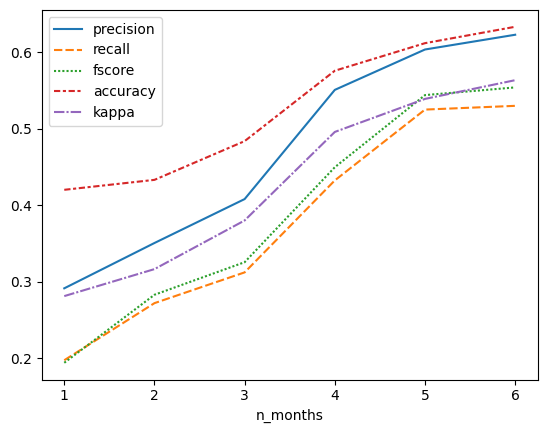

In [81]:
sns.lineplot(data=rf_test_scores)

In [64]:
rf_best_models_hyperparams = get_best_models_hyperparams(rf_results, rf_hyperparameters)
rf_best_models_hyperparams

,n_months,n_estimators,max_depth
0,1,120,10
1,2,190,16
2,3,380,19
3,4,450,17
4,5,380,19
5,6,380,19


In [24]:
rf_cross_val_scores = get_cross_val_scores(rf_results)
rf_cross_val_scores.head()

,n_months,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,...,split2_test_fscore,mean_test_fscore,std_test_fscore,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa
0,1,7.370475,0.009758,0.203622,0.002576,210,4,"{'n_estimators': 210, 'max_depth': 4}",0.413681,0.405945,...,0.322079,0.328246,0.015061,94,0.241618,0.260971,0.258536,0.253708,0.008607,93
1,1,27.915622,0.916207,0.371727,0.042255,280,19,"{'n_estimators': 280, 'max_depth': 19}",0.422638,0.436889,...,0.401712,0.403344,0.015289,2,0.293189,0.318691,0.298438,0.303439,0.010995,7
2,1,20.327585,1.269749,0.368862,0.044080,320,7,"{'n_estimators': 320, 'max_depth': 7}",0.423453,0.425081,...,0.373214,0.375514,0.011742,77,0.279759,0.297248,0.287861,0.288289,0.007146,74
3,1,33.415080,1.393729,0.403189,0.004466,390,14,"{'n_estimators': 390, 'max_depth': 14}",0.419788,0.440147,...,0.403005,0.402490,0.017026,4,0.289288,0.321766,0.304233,0.305096,0.013273,1
4,1,10.554142,0.855736,0.289420,0.005627,400,3,"{'n_estimators': 400, 'max_depth': 3}",0.410016,0.378257,...,0.309574,0.301701,0.006583,97,0.228627,0.215265,0.245567,0.229820,0.012399,97


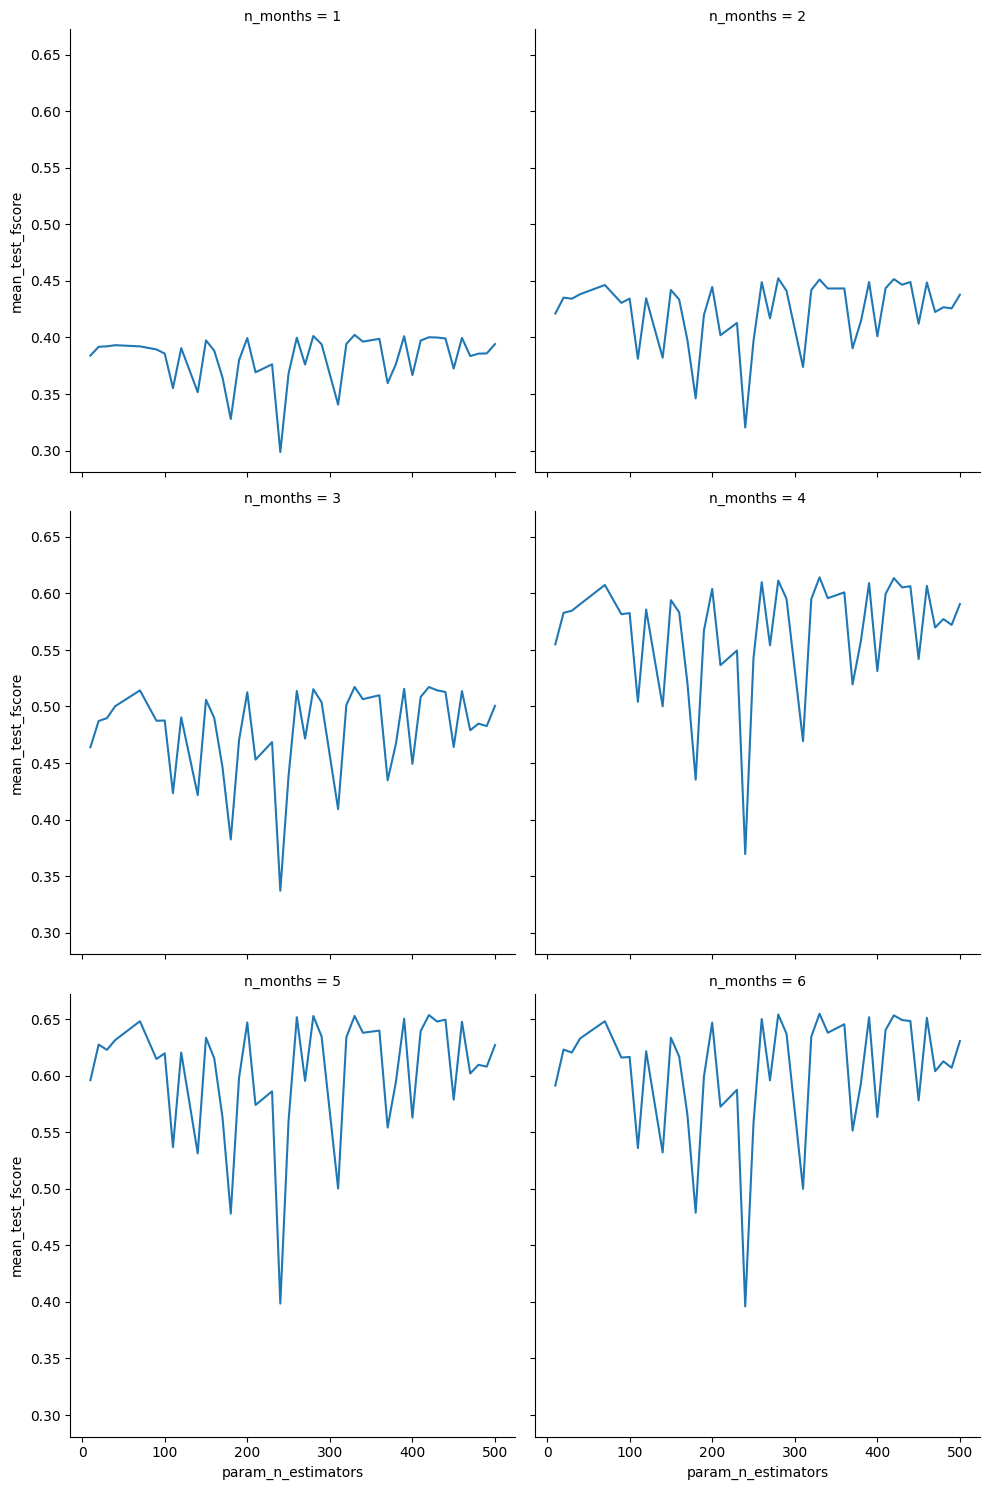

In [107]:
plot_cross_val_scores(rf_cross_val_scores, "n_estimators", "fscore")

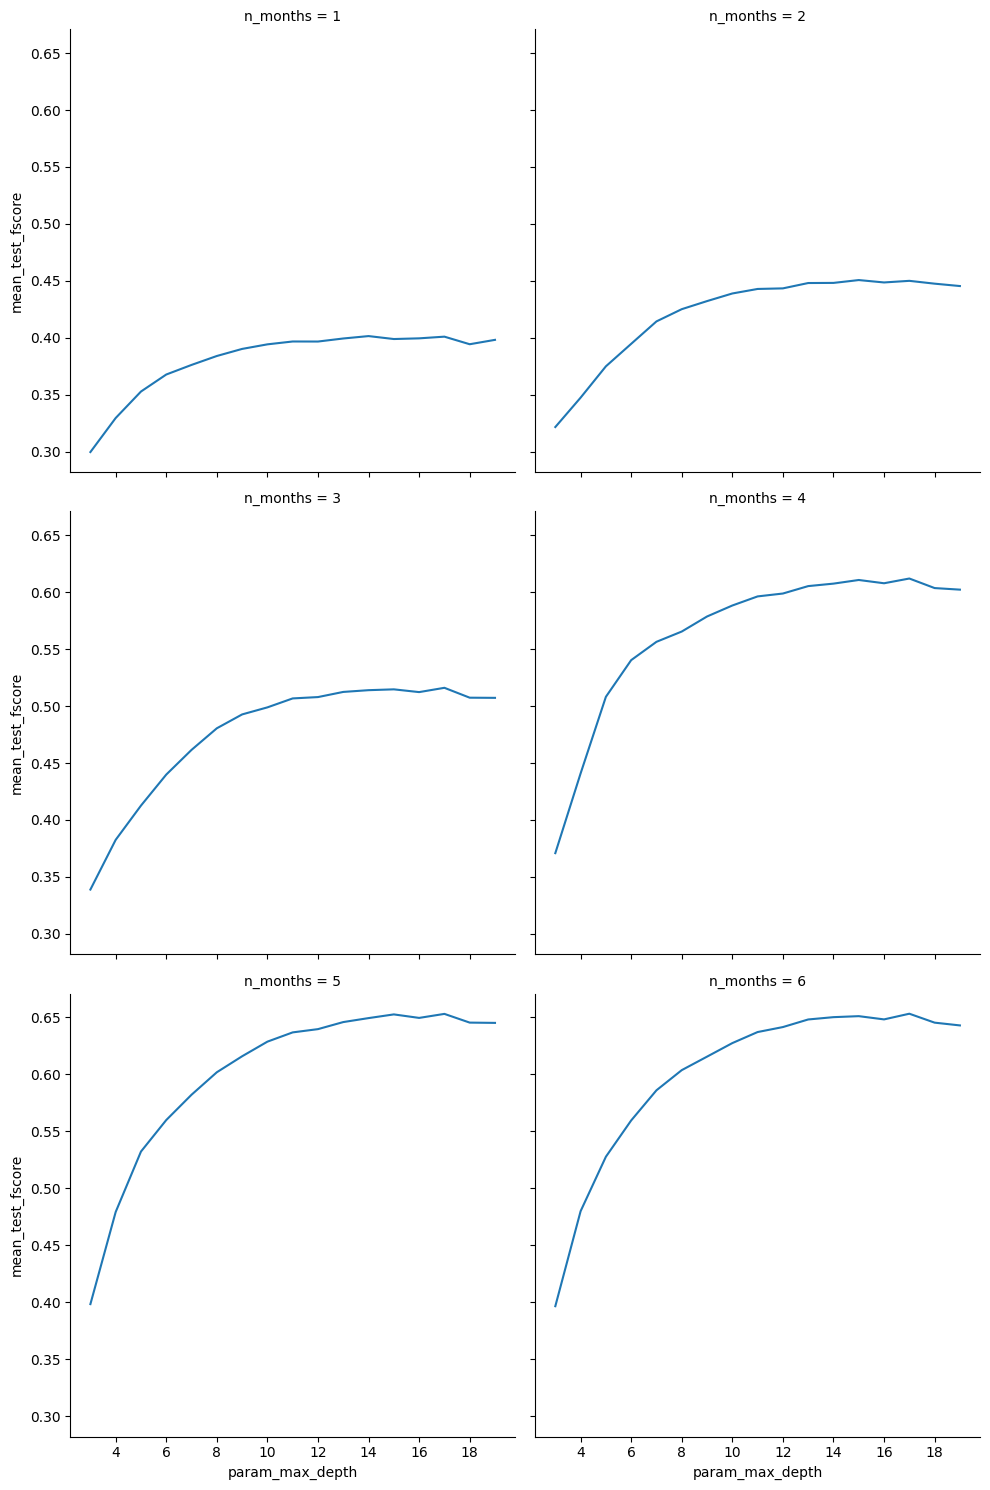

In [25]:
plot_cross_val_scores(rf_cross_val_scores, "max_depth", "fscore")

### LightGBM

In [26]:
with open(dumps_path / "lgbm_results.dump", "rb") as f:
    lgbm_results = pickle.load(f)

In [27]:
lgbm_test_scores = get_test_scores(lgbm_results)
lgbm_test_scores

,precision,recall,fscore,accuracy,kappa
n_months,,,,,
1,0.287911,0.236003,0.240268,0.434866,0.305292
2,0.369433,0.261941,0.272470,0.443364,0.328531
3,0.426820,0.345588,0.363325,0.507049,0.410311
4,0.582904,0.473992,0.502310,0.610112,0.537345
5,0.647952,0.555504,0.583152,0.658240,0.594288
6,0.699869,0.579769,0.611136,0.671366,0.610197


<AxesSubplot: xlabel='n_months'>

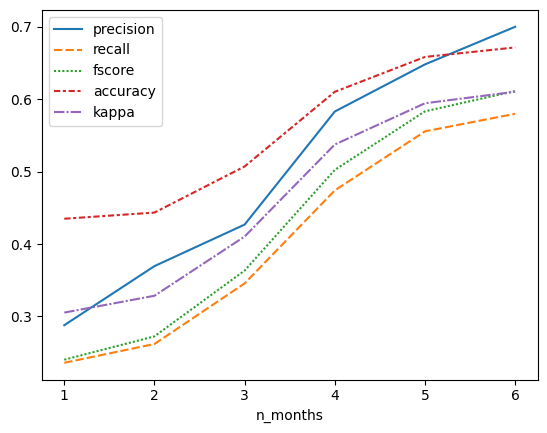

In [15]:
sns.lineplot(data=lgbm_test_scores)

In [16]:
lgbm_best_models_hyperparams = get_best_models_hyperparams(lgbm_results, lgbm_hyperparameters)
lgbm_best_models_hyperparams

,n_months,boosting_type,n_estimators,max_depth,learning_rate
0,1,dart,180,6,0.1
1,2,dart,490,9,0.1
2,3,dart,490,9,0.1
3,4,dart,490,9,0.1
4,5,dart,490,9,0.1
5,6,dart,490,9,0.1


In [17]:
lgbm_cross_val_scores = get_cross_val_scores(lgbm_results)
lgbm_cross_val_scores.head()

,n_months,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_boosting_type,params,...,split2_test_fscore,mean_test_fscore,std_test_fscore,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa
0,1,62.565919,0.702547,1.631035,0.308468,160,9,0.01,dart,"{'n_estimators': 160, 'max_depth': 9, 'learnin...",...,0.391067,0.391045,0.018023,25,0.278941,0.310198,0.292588,0.293909,0.012795,25
1,1,97.275526,2.611655,2.399570,0.245901,250,8,0.01,dart,"{'n_estimators': 250, 'max_depth': 8, 'learnin...",...,0.396137,0.395851,0.011406,19,0.288831,0.305718,0.294205,0.296251,0.007044,22
2,1,41.534364,0.769820,0.892457,0.044860,160,5,0.001,dart,"{'n_estimators': 160, 'max_depth': 5, 'learnin...",...,0.166333,0.157786,0.006055,43,0.004429,0.003623,0.015651,0.007901,0.005490,43
3,1,83.167441,0.415336,2.379344,0.237520,290,5,0.01,dart,"{'n_estimators': 290, 'max_depth': 5, 'learnin...",...,0.399947,0.394347,0.013081,22,0.287261,0.305671,0.308669,0.300533,0.009464,16
4,1,132.289003,0.249212,2.988849,0.133982,340,7,0.001,dart,"{'n_estimators': 340, 'max_depth': 7, 'learnin...",...,0.297015,0.292511,0.013849,34,0.160921,0.206313,0.202825,0.190019,0.020625,35


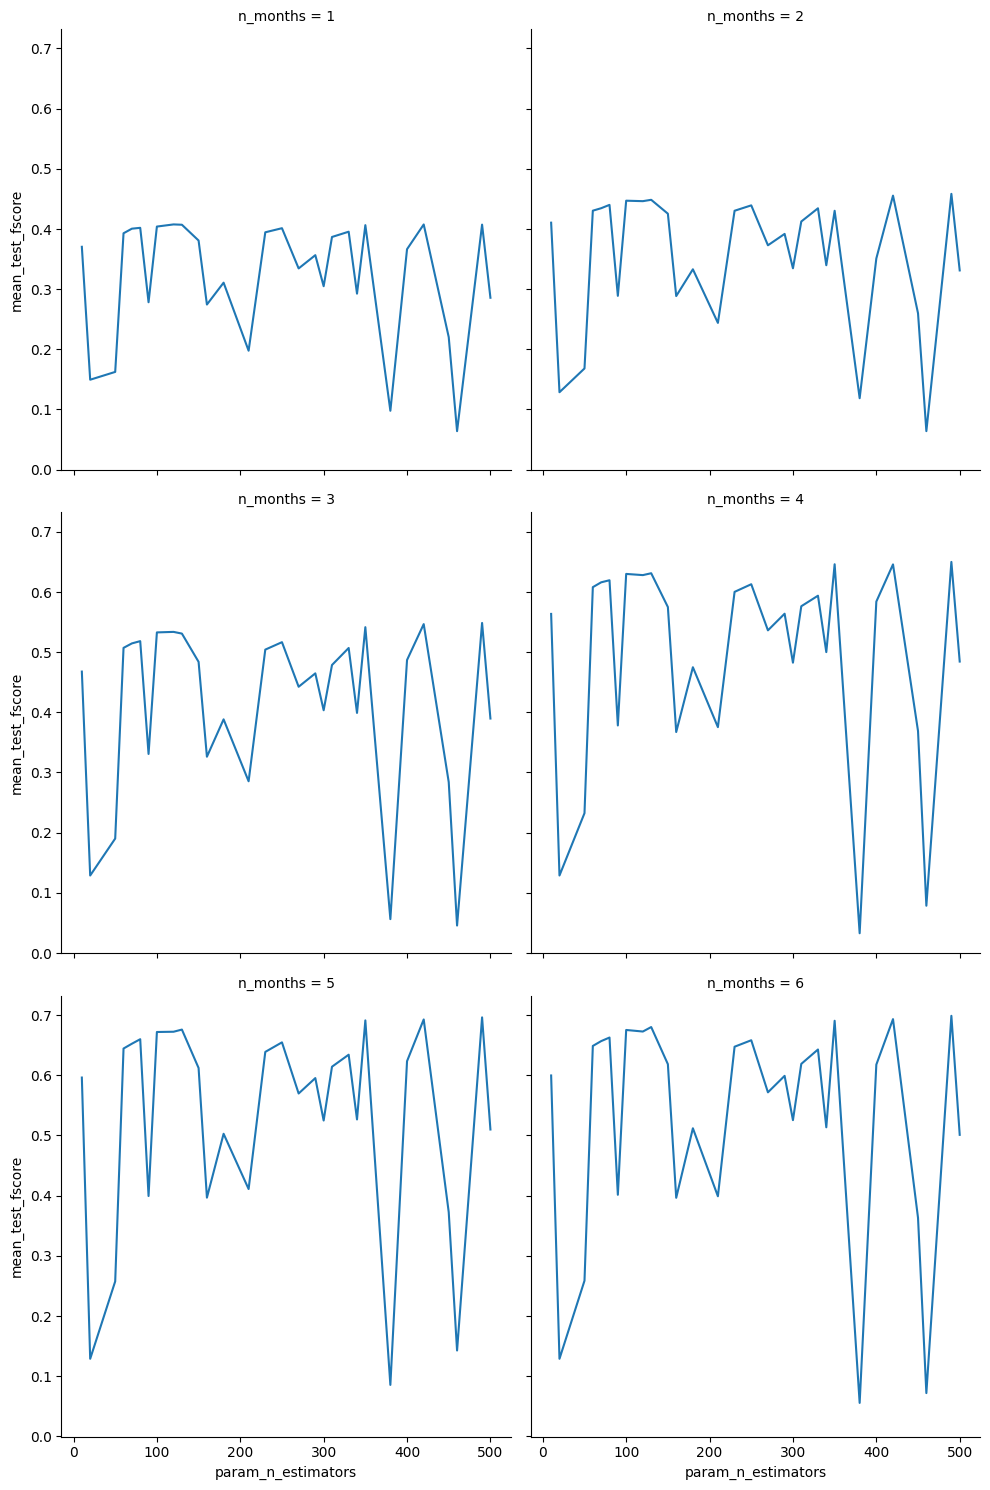

In [18]:
plot_cross_val_scores(lgbm_cross_val_scores, "n_estimators", "fscore")

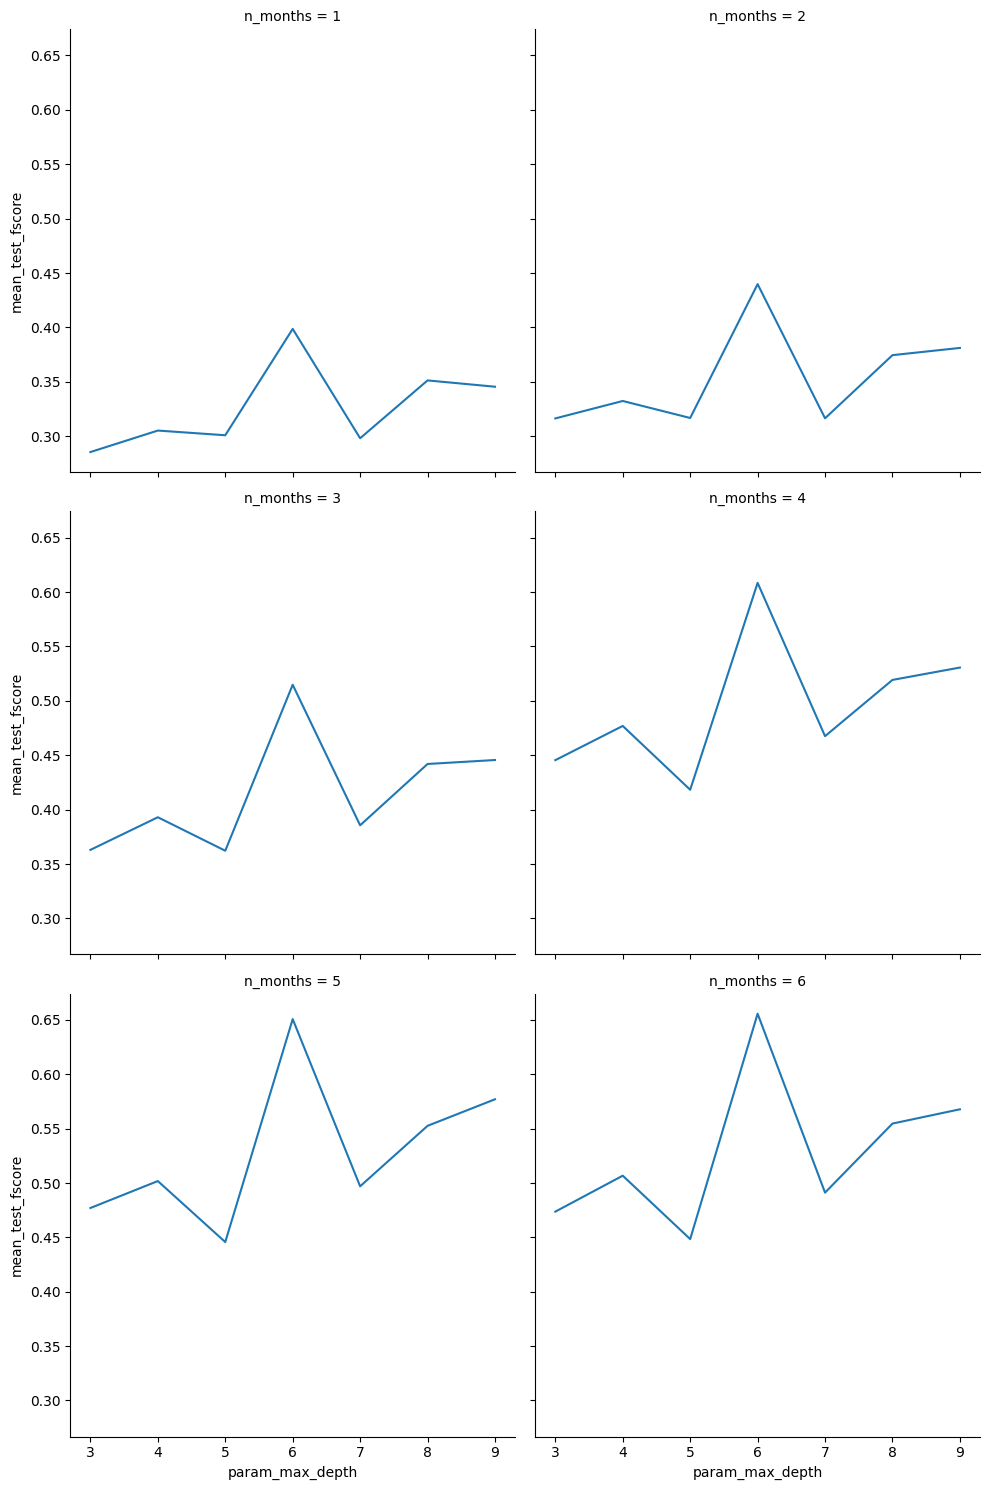

In [19]:
plot_cross_val_scores(lgbm_cross_val_scores, "max_depth", "fscore")

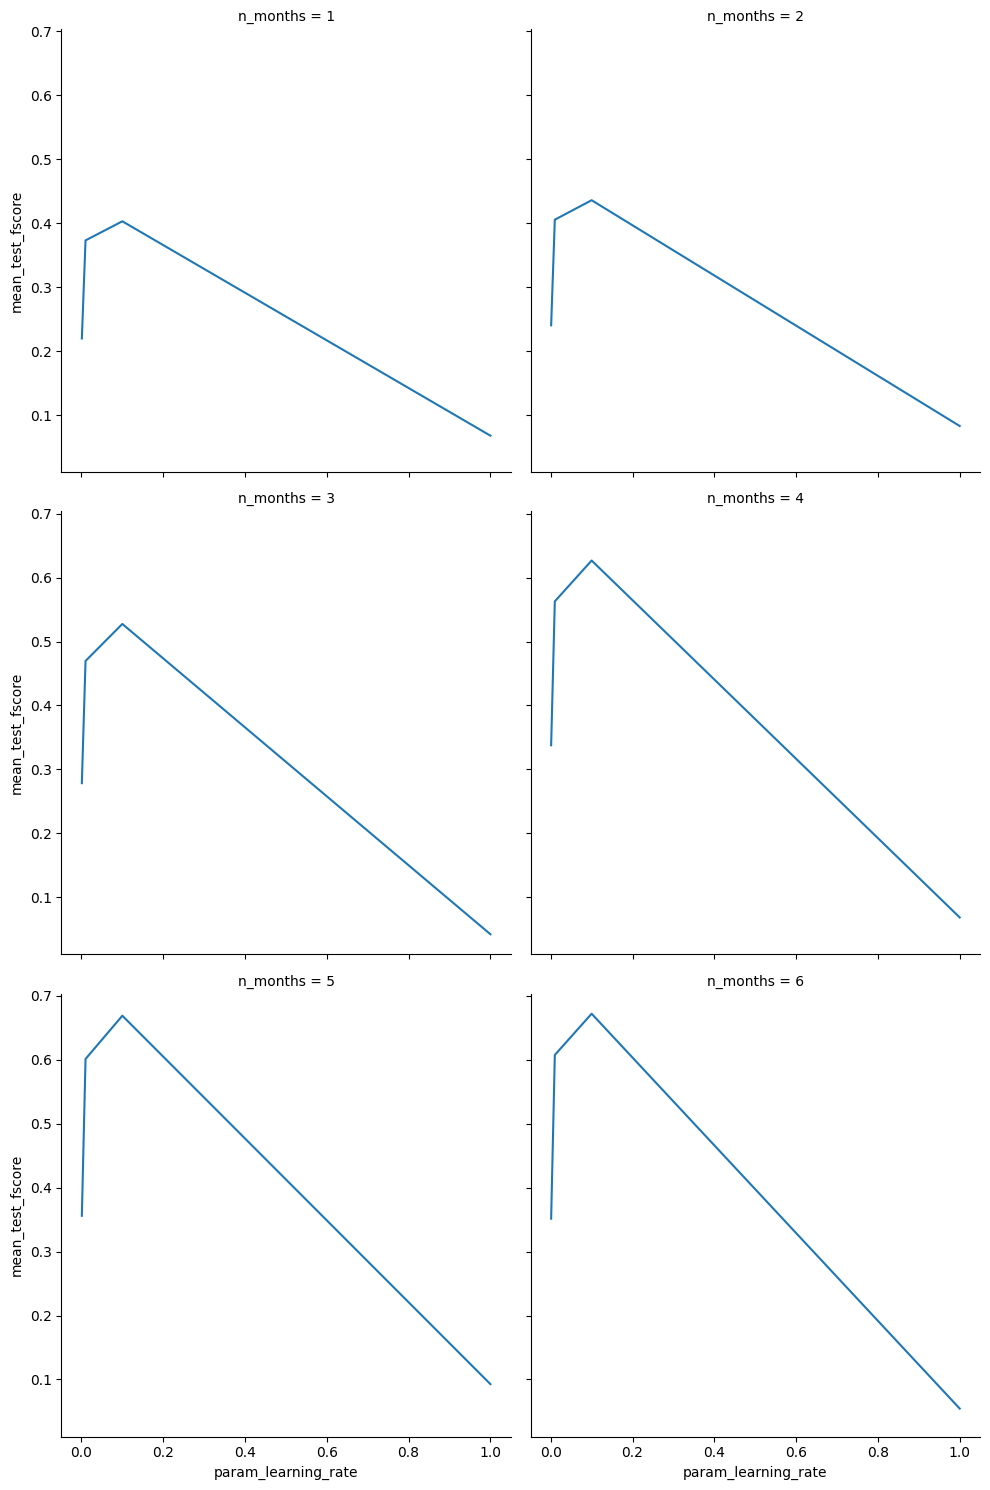

In [20]:
plot_cross_val_scores(lgbm_cross_val_scores, "learning_rate", "fscore")

### Catboost

In [28]:
with open(dumps_path / "catboost_results.dump", "rb") as f:
    catboost_results = pickle.load(f)

In [29]:
catboost_test_scores = get_test_scores(catboost_results)
catboost_test_scores

,precision,recall,fscore,accuracy,kappa
n_months,,,,,
1,0.254429,0.211661,0.209351,0.422733,0.291621
2,0.331298,0.270775,0.281945,0.419543,0.305345
3,0.390289,0.334841,0.347688,0.481283,0.379250
4,0.541632,0.450876,0.470199,0.579485,0.501464
5,0.605761,0.524483,0.545130,0.616432,0.547281
6,0.610357,0.538541,0.559443,0.630530,0.562636


<AxesSubplot: xlabel='n_months'>

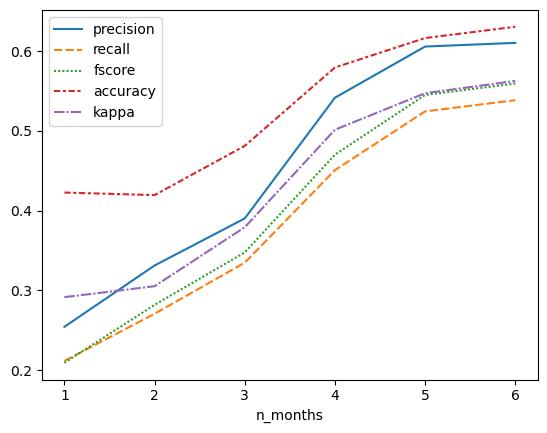

In [14]:
sns.lineplot(data=catboost_test_scores)

In [20]:
catboost_results

defaultdict(dict, {1: {}, 2: {}})

In [22]:
catboost_best_models_hyperparams = get_best_models_hyperparams(catboost_results, catboost_hyperparameters)
catboost_best_models_hyperparams

,n_months,iterations,depth
0,1,190,3
1,2,190,4
2,3,170,3
3,4,190,4
4,5,190,6
5,6,190,4


In [23]:
catboost_cross_val_scores = get_cross_val_scores(catboost_results)
catboost_cross_val_scores.head()

,n_months,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_depth,params,split0_test_accuracy,split1_test_accuracy,...,split2_test_fscore,mean_test_fscore,std_test_fscore,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa
0,1,14.257454,0.243732,0.112536,0.003629,190,4,"{'iterations': 190, 'depth': 4}",0.410831,0.430782,...,0.399387,0.398672,0.015736,4,0.282726,0.311728,0.286683,0.293712,0.012841,5
1,1,9.723388,0.174220,0.109062,0.001629,130,4,"{'iterations': 130, 'depth': 4}",0.413274,0.432410,...,0.393782,0.398123,0.017091,5,0.284473,0.316096,0.283123,0.294564,0.015236,4
2,1,9.070178,0.214100,0.110162,0.001703,110,4,"{'iterations': 110, 'depth': 4}",0.409609,0.424267,...,0.385547,0.393323,0.015813,11,0.279838,0.307382,0.273284,0.286835,0.014774,11
3,1,17.952922,0.137951,0.119128,0.019834,130,5,"{'iterations': 130, 'depth': 5}",0.403909,0.422231,...,0.389724,0.392328,0.018132,13,0.274147,0.305629,0.275910,0.285229,0.014443,12
4,1,4.571381,0.328386,0.122917,0.019214,90,3,"{'iterations': 90, 'depth': 3}",0.405945,0.404316,...,0.384209,0.380088,0.008498,19,0.271248,0.278788,0.273494,0.274510,0.003161,18


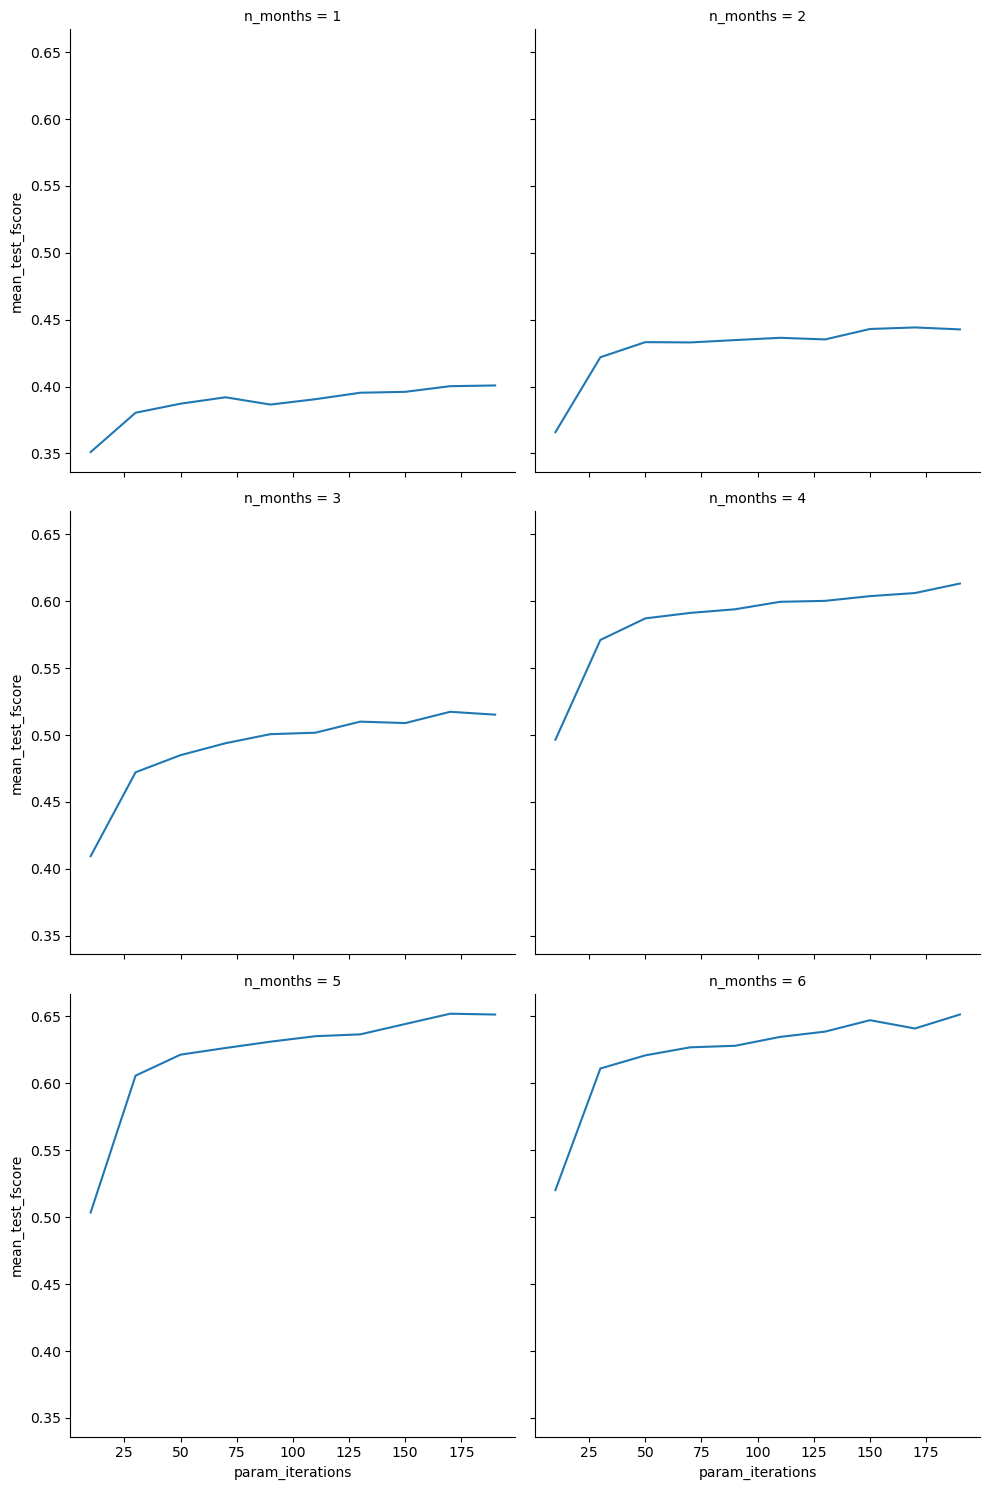

In [24]:
plot_cross_val_scores(catboost_cross_val_scores, "iterations", "fscore")

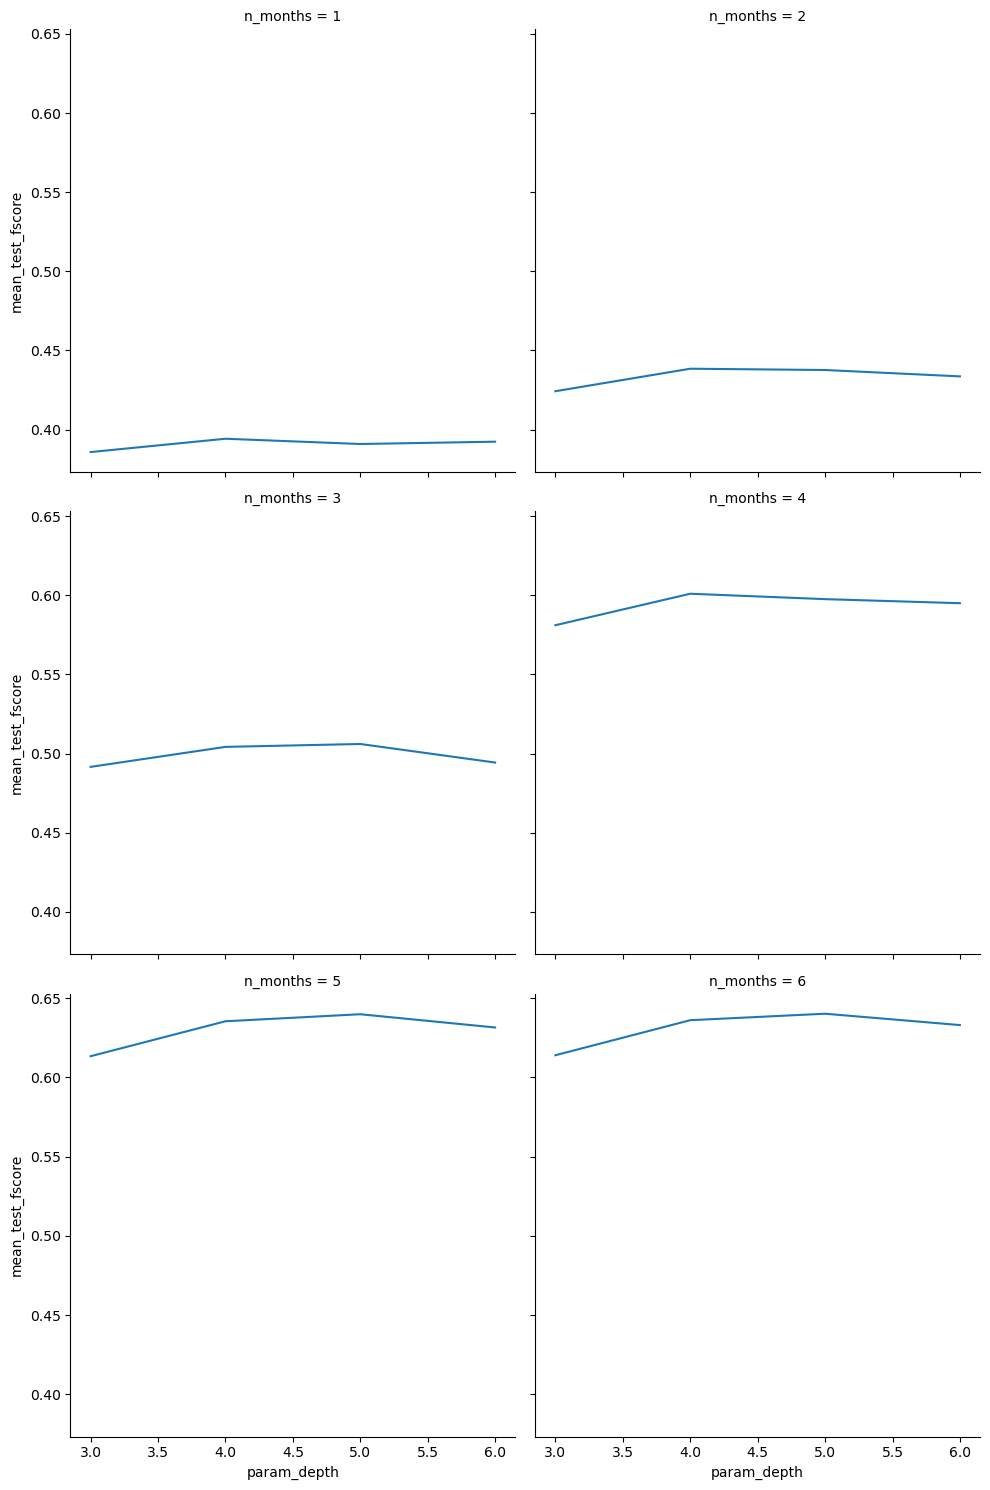

In [25]:
plot_cross_val_scores(catboost_cross_val_scores, "depth", "fscore")

### Transformer

In [30]:
with open(dumps_path / "transformer_results.dump", "rb") as f:
    transformer_results = pickle.load(f)

In [31]:
transformer_stats = get_nn_stats(transformer_results)
transformer_stats

,n_months,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward
0,1,1,2.164863,2.164025,0.334610,0.080450,0.130607,0.082835,0.178547,0.0,2.164025,0.0
1,1,2,1.834171,1.959686,0.402937,0.137619,0.167097,0.131341,0.258547,0.0,1.959686,0.0
2,1,3,1.734384,1.965687,0.352490,0.098935,0.131006,0.107865,0.202830,0.0,1.965687,0.0
3,1,4,1.700843,1.869757,0.385057,0.118057,0.162074,0.131930,0.244760,0.0,1.869757,0.0
4,1,5,1.655430,1.886829,0.390805,0.128462,0.165679,0.137739,0.249931,0.0,1.886829,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45,6,46,0.630254,1.211365,0.661643,0.561043,0.636706,0.583502,0.605641,0.0,1.211365,0.0
46,6,47,0.644966,1.196139,0.645600,0.588790,0.619502,0.582881,0.581662,0.0,1.196139,0.0
47,6,48,0.634542,1.191061,0.641225,0.568330,0.627550,0.583098,0.581197,0.0,1.191061,0.0
48,6,49,0.630468,1.157896,0.666991,0.618344,0.652101,0.623767,0.611503,0.0,1.157896,0.0


In [32]:
transformer_test_scores = get_nn_test_scores(transformer_results)
transformer_test_scores

,accuracy,precision,recall,fscore,kappa
n_months,,,,,
1,0.434227,0.226070,0.199850,0.179082,0.302674
2,0.435586,0.332702,0.318027,0.285381,0.333108
3,0.545455,0.478082,0.421713,0.406211,0.461586
4,0.635391,0.547909,0.562677,0.541046,0.570105
5,0.674283,0.692463,0.654432,0.635865,0.616070
6,0.683034,0.659756,0.652101,0.628773,0.626026


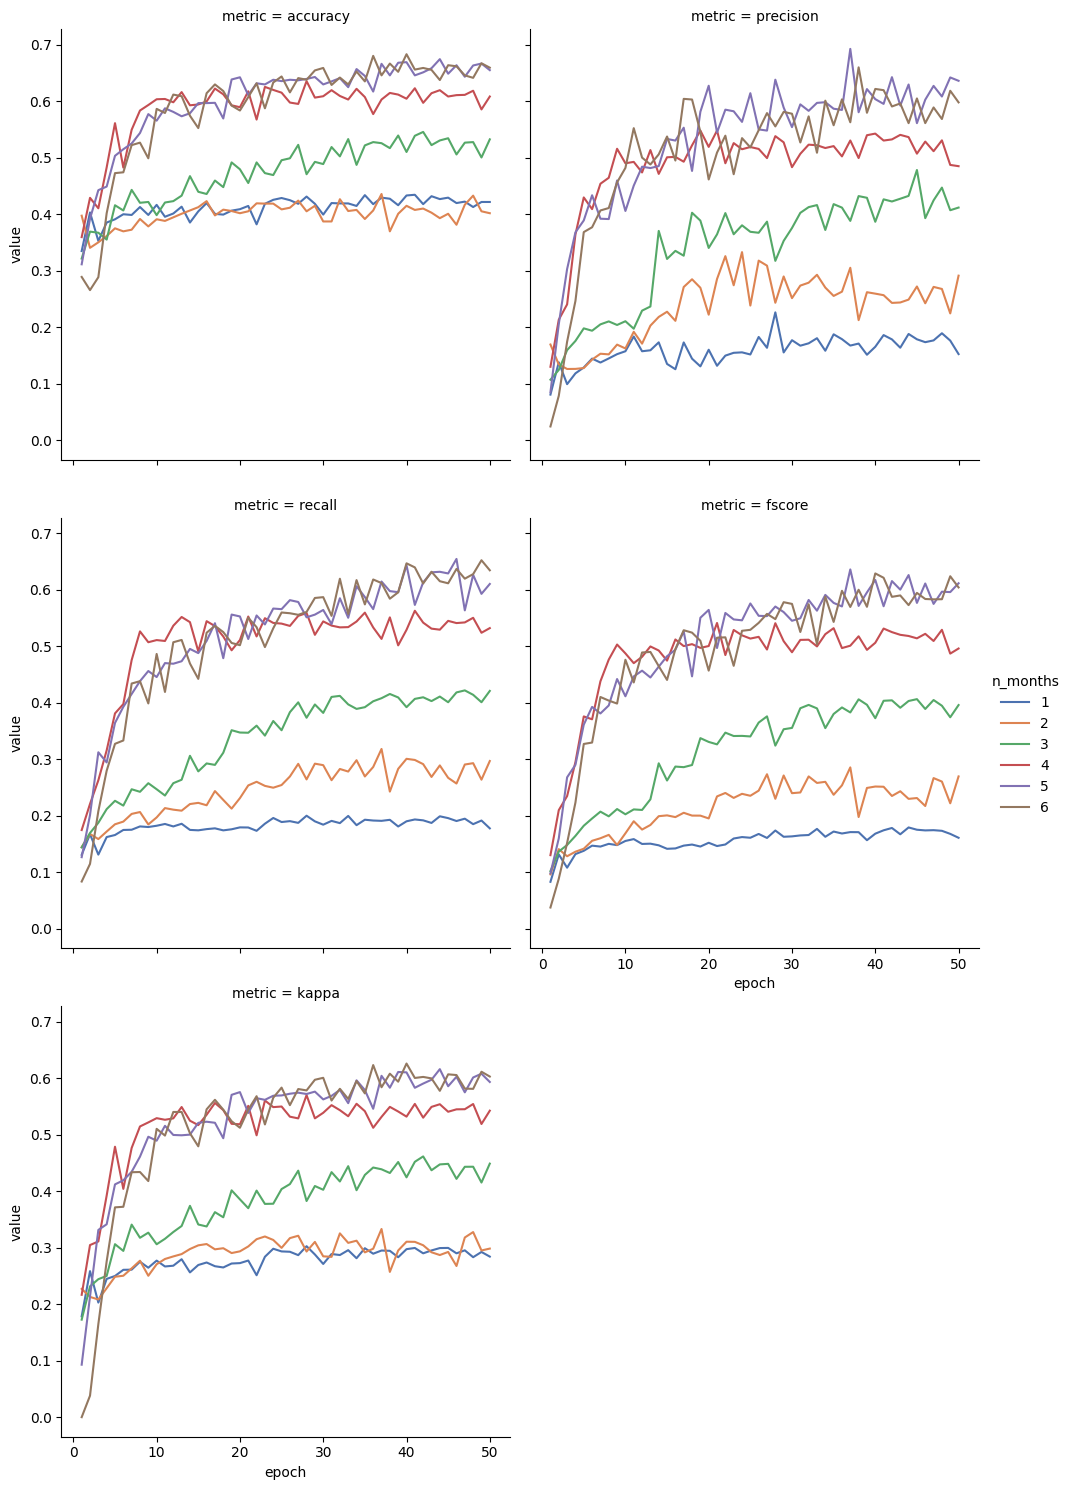

In [35]:
plot_nn_learning_curves(transformer_stats)

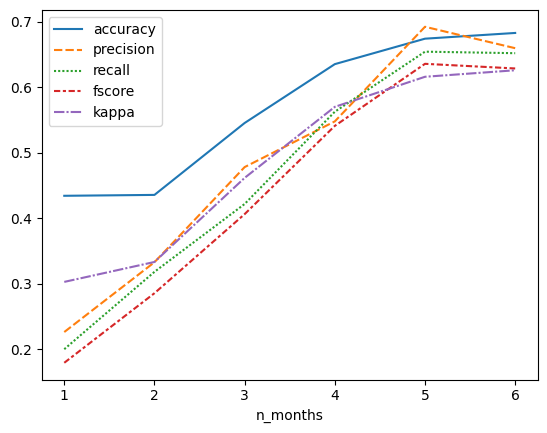

In [62]:
plot_nn_monthly_scores(transformer_stats)

### TempCNN

In [33]:
with open(dumps_path / "tempcnn_results.dump", "rb") as f:
    tempcnn_results = pickle.load(f)

In [34]:
tempcnn_stats = get_nn_stats(tempcnn_results)
tempcnn_stats

,n_months,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward
0,1,1,1.779231,1.886465,0.371009,0.130860,0.150814,0.118219,0.226022,0.0,1.886465,0.0
1,1,2,1.638667,1.948532,0.390805,0.137709,0.152537,0.114590,0.240617,0.0,1.948532,0.0
2,1,3,1.581900,1.695714,0.431034,0.160501,0.186061,0.155108,0.296028,0.0,1.695714,0.0
3,1,4,1.536605,1.909979,0.389527,0.186314,0.160640,0.134393,0.253031,0.0,1.909979,0.0
4,1,5,1.507347,2.053661,0.318646,0.270859,0.178312,0.123192,0.201938,0.0,2.053661,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35,6,36,0.186993,1.790802,0.660185,0.637165,0.639291,0.631307,0.603445,0.0,1.790802,0.0
36,6,37,0.193466,2.338954,0.573165,0.564717,0.549159,0.533531,0.505437,0.0,2.338954,0.0
37,6,38,0.187609,3.256398,0.540107,0.529186,0.536709,0.490334,0.472807,0.0,3.256398,0.0
38,6,39,0.169398,1.895165,0.620321,0.615730,0.573193,0.575947,0.551946,0.0,1.895165,0.0


In [35]:
tempcnn_test_scores = get_nn_test_scores(tempcnn_results)
tempcnn_test_scores

,accuracy,precision,recall,fscore,kappa
n_months,,,,,
1,0.482759,0.355038,0.278037,0.269079,0.365423
2,0.479339,0.414497,0.341042,0.332393,0.374485
3,0.560039,0.532401,0.455581,0.457785,0.476965
4,0.652406,0.678498,0.597064,0.602444,0.590978
5,0.694215,0.704523,0.687345,0.676415,0.641100
6,0.700049,0.687826,0.665973,0.644919,0.645314


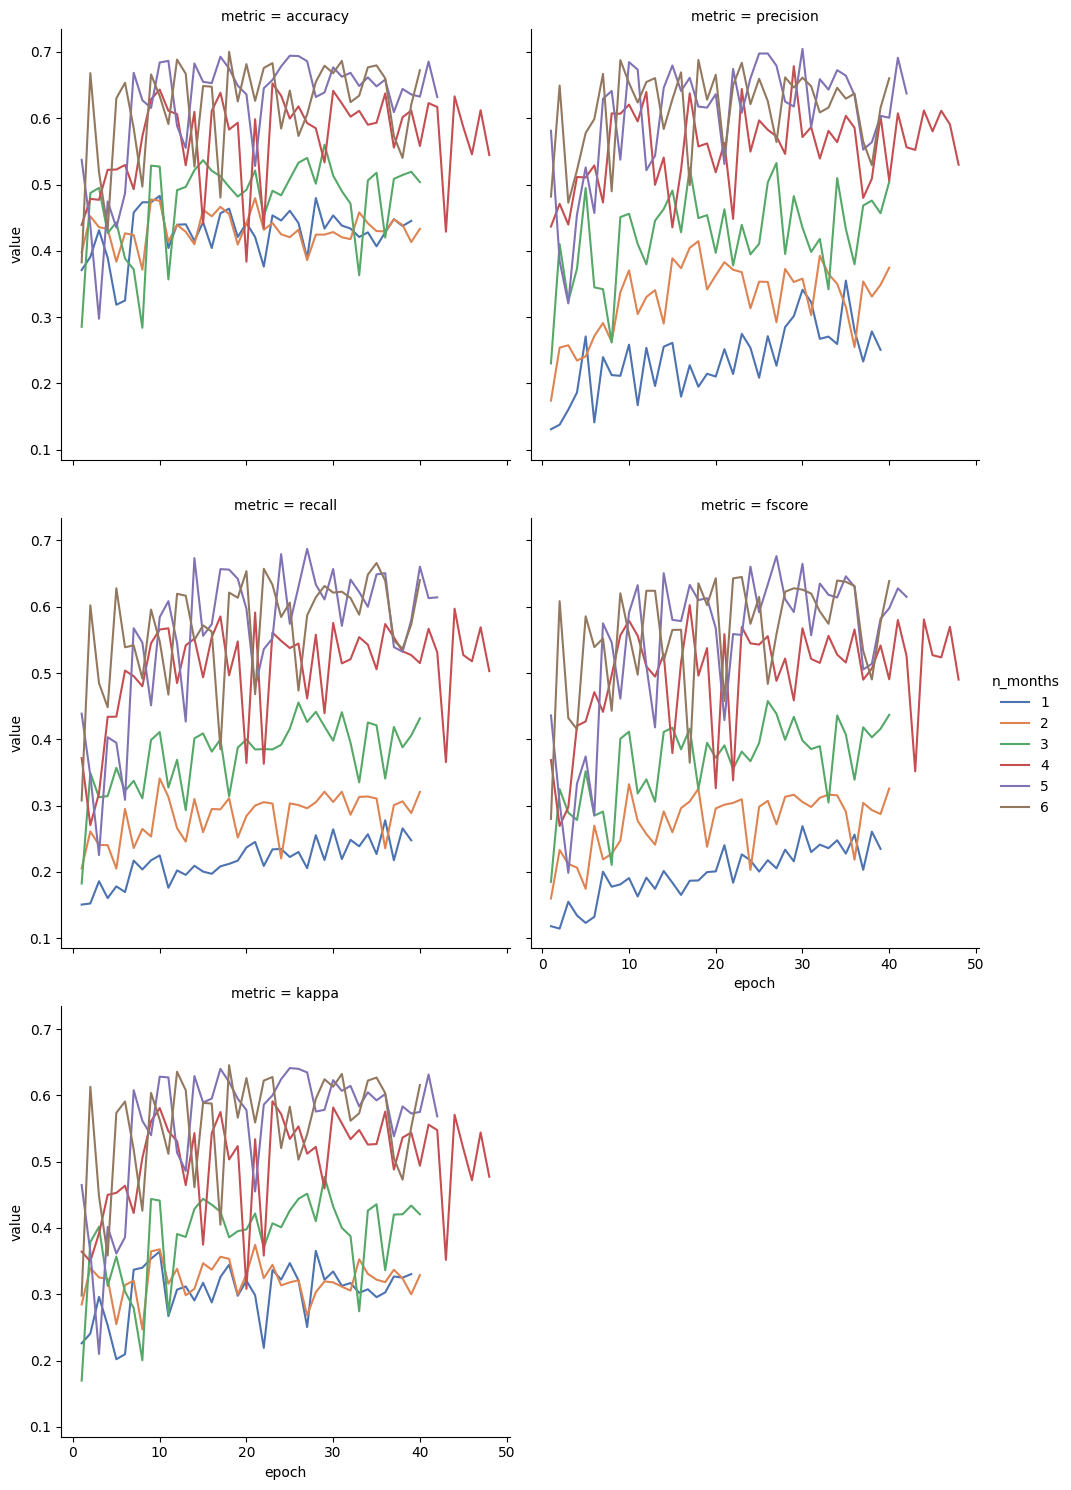

In [49]:
plot_nn_learning_curves(tempcnn_stats)

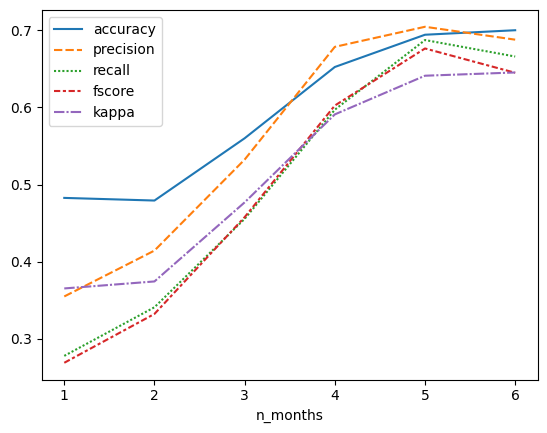

In [64]:
plot_nn_monthly_scores(tempcnn_stats)

### EarlyRNN

In [36]:
with open(dumps_path / "earlyrnn_results.dump", "rb") as f:
    earlyrnn_results = pickle.load(f)

In [37]:
earlyrnn_stats, earlyrnn_monthly_scores = get_early_nn_stats(earlyrnn_results)
earlyrnn_stats

,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward,avg_t_stop
0,1,10.016619,9.649319,0.388916,0.078742,0.139226,0.095962,0.215567,0.023590,20.606073,1.307436,57.608167
1,2,8.851527,9.307733,0.400097,0.188680,0.165415,0.124906,0.246828,0.162339,20.040218,1.424755,49.421974
2,3,8.635777,8.764891,0.434614,0.166475,0.178910,0.141198,0.274448,0.220059,19.029627,1.499847,46.016529
3,4,7.976877,8.802876,0.446767,0.252618,0.254371,0.233800,0.320337,0.278660,19.259501,1.653748,42.559067
4,5,7.524632,8.914606,0.449198,0.200581,0.221045,0.187438,0.327387,0.283093,19.533426,1.704211,42.297521
5,6,6.972530,8.529814,0.494895,0.378817,0.286312,0.283292,0.389550,0.313547,18.934784,1.875155,40.500729
6,7,6.529585,7.895523,0.503646,0.396691,0.269753,0.263558,0.395056,0.314849,17.778324,1.987275,40.423918
7,8,6.020234,7.374332,0.565873,0.382306,0.346623,0.342332,0.480685,0.289512,16.839314,2.090651,41.918814
8,9,5.670801,7.605137,0.582888,0.487975,0.427061,0.436689,0.508447,0.292247,17.202049,1.991775,41.757414
9,10,5.344767,7.098500,0.608167,0.511765,0.475887,0.484454,0.534103,0.341125,16.383713,2.186712,38.873602


In [38]:
earlyrnn_monthly_scores

,accuracy,precision,recall,fscore,kappa
n_months,,,,,
1,0.446767,0.320224,0.258744,0.243645,0.327118
2,0.499757,0.411340,0.340481,0.341274,0.397789
3,0.583374,0.573582,0.477263,0.463353,0.505038
4,0.663588,0.620240,0.612934,0.591640,0.604979
5,0.699076,0.661726,0.646797,0.639150,0.646920
6,0.703452,0.670469,0.645270,0.631872,0.652495


<AxesSubplot: xlabel='epoch', ylabel='value'>

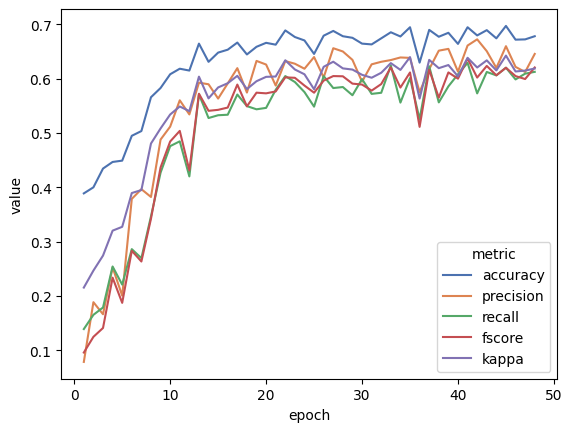

In [57]:
sns.lineplot(
    data=earlyrnn_stats.melt(
        id_vars="epoch",
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    ),
    x="epoch", y="value", hue="metric",
    palette="deep"
)

<AxesSubplot: xlabel='n_months'>

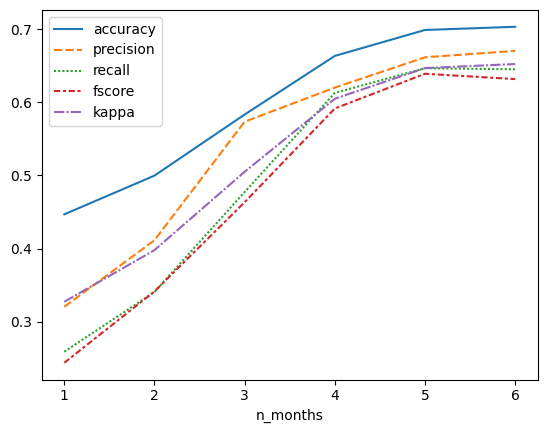

In [58]:
sns.lineplot(data=earlyrnn_monthly_scores)

### EarlyTempCNN

In [17]:
with open(dumps_path / "earlytempcnn_results.dump", "rb") as f:
    earlytempcnn_results = pickle.load(f)

In [11]:
earlytempcnn_stats, earlytempcnn_monthly_scores = get_early_nn_stats(earlytempcnn_results)
earlytempcnn_stats

,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward,avg_t_stop
0,1,9.420223,7.816092,0.502188,0.219685,0.256902,0.227808,0.393708,0.000000,17.486763,1.854578,59.000000
1,2,7.184675,8.766914,0.404473,0.258622,0.268333,0.215738,0.309670,0.000783,19.340389,1.806562,58.953816
2,3,6.495049,6.671977,0.551774,0.338696,0.376892,0.348586,0.467974,0.264858,15.838741,2.494788,43.373359
3,4,5.530113,6.454845,0.586291,0.595158,0.421040,0.439788,0.502458,0.418933,15.844897,2.935206,34.282936
4,5,4.712826,5.873924,0.618862,0.583604,0.499339,0.500230,0.549823,0.542175,14.785194,3.037348,27.011667
5,6,4.086309,6.042564,0.625182,0.610073,0.463005,0.489680,0.554589,0.805896,15.302486,3.217358,11.452115
6,7,3.785012,5.838645,0.639767,0.572854,0.512310,0.511588,0.575392,0.879205,15.002940,3.325652,7.126884
7,8,3.563228,5.279687,0.641711,0.588375,0.502694,0.517565,0.577630,0.968219,14.100201,3.540828,1.875061
8,9,3.271591,5.226991,0.666018,0.595191,0.573240,0.567788,0.607576,0.945956,14.070137,3.616155,3.188624
9,10,3.049067,5.221656,0.663588,0.664130,0.537833,0.556563,0.604281,0.980595,14.088112,3.644800,1.144871


In [12]:
earlytempcnn_monthly_scores

,accuracy,precision,recall,fscore,kappa
n_months,,,,,
1,0.715119,0.674769,0.665779,0.654964,0.664811
2,0.709285,0.666343,0.662667,0.649129,0.658050
3,0.714147,0.669858,0.662542,0.646946,0.663729
4,0.709285,0.669266,0.665272,0.651851,0.658284
5,0.714147,0.676941,0.649140,0.651654,0.663751
6,0.709772,0.677085,0.661166,0.651068,0.658760


<AxesSubplot: xlabel='epoch', ylabel='value'>

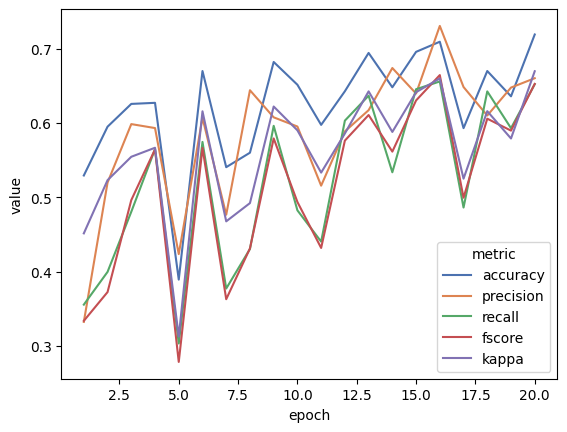

In [14]:
sns.lineplot(
    data=earlytempcnn_stats.melt(
        id_vars="epoch",
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    ),
    x="epoch", y="value", hue="metric",
    palette="deep"
)

## Models Comparison

In [39]:
def join_test_scores(test_scores: dict):
    dfs = []
    for model_type, scores in test_scores.items():
        scores = scores.copy()
        scores.insert(0, "model", model_type)
        dfs.append(scores)
    df = pd.concat(dfs)
    df.reset_index(inplace=True)
    
    return df        

In [40]:
joint_test_scores = join_test_scores(
    dict(
        rf=rf_test_scores,
        lgbm=lgbm_test_scores,
        catboost=catboost_test_scores,
        transformer=transformer_test_scores,
        tempcnn=tempcnn_test_scores,
        earlyrnn=earlyrnn_monthly_scores,
        earlytempcnn=earlytempcnn_monthly_scores
    )
)
joint_test_scores

,n_months,model,precision,recall,fscore,accuracy,kappa
0,1,rf,0.291604,0.197748,0.194408,0.420179,0.281443
1,2,rf,0.350740,0.272243,0.283167,0.433155,0.316655
2,3,rf,0.408085,0.312400,0.325694,0.483714,0.380185
3,4,rf,0.550606,0.432433,0.449651,0.575596,0.495713
4,5,rf,0.603304,0.524887,0.543791,0.611570,0.538830
5,6,rf,0.622563,0.529773,0.553829,0.632961,0.563260
6,1,lgbm,0.287911,0.236003,0.240268,0.434866,0.305292
7,2,lgbm,0.369433,0.261941,0.272470,0.443364,0.328531
8,3,lgbm,0.426820,0.345588,0.363325,0.507049,0.410311
9,4,lgbm,0.582904,0.473992,0.502310,0.610112,0.537345


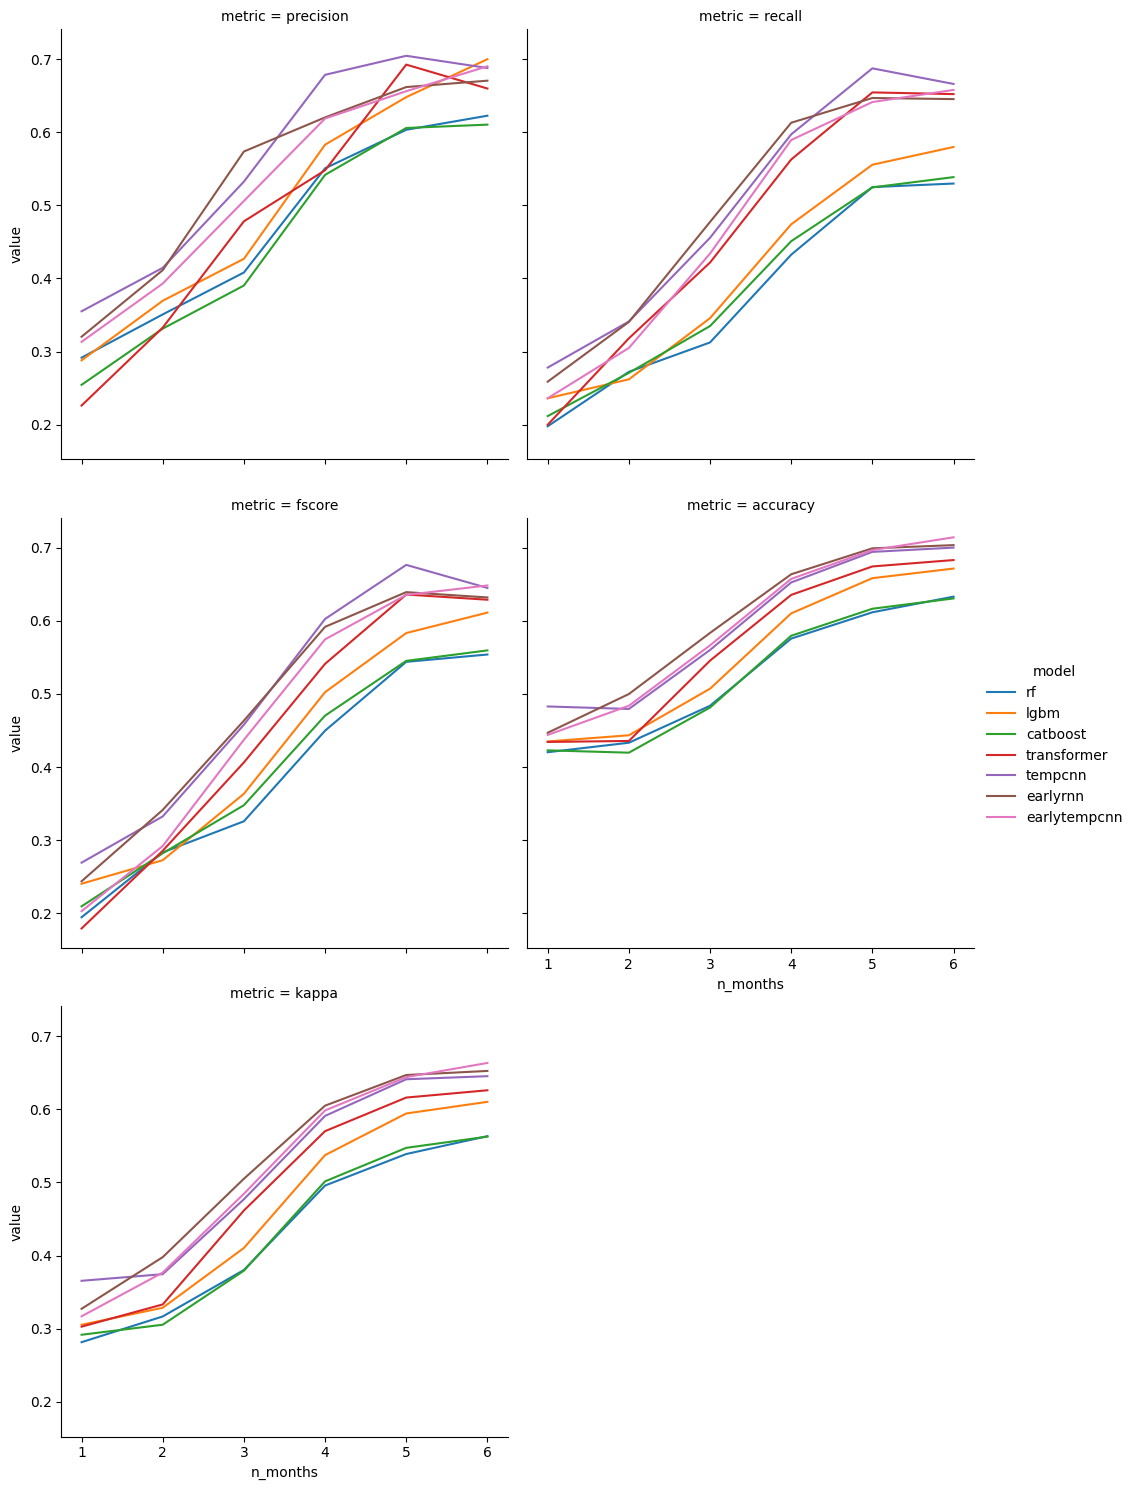

In [41]:
sns.relplot(
    data=joint_test_scores.melt(id_vars=["n_months", "model"], var_name="metric"),
    x="n_months", y="value", hue="model", col="metric", kind="line", col_wrap=2
)

# Part 3. Inference

In [1]:
from data.russia import Russia


ds = Russia(root="/home/pavel/elects_data/russia/", partition="test")

/home/pavel/.venv/hse/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057


In [22]:
def plot_early_nn_predictions(dataset, model, index, T):
    X, y = dataset[index]
    model.eval()
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(X)
    ax.set_title(dataset.crops[y[0].item()])
    sns.despine(offset=0.2)

    log_class_probabilities, probabilitiy_stopping = model(X[:T].unsqueeze(0))

    fig, axs = plt.subplots(2,1, figsize=(16, 8))
    ax = axs[0]
    ax.plot(log_class_probabilities[0].exp().detach().numpy())
    ax.set_ylim(0,1)
    ax.legend(ds.crops.values(), loc=1)
    ax.set_title(f"classification probabilities (correct class = {dataset.crops[y[0].item()]})")
    ax = axs[1]
    ax.bar(x = np.arange(probabilitiy_stopping.shape[1]), height = probabilitiy_stopping[0].detach().numpy())
    ax.set_title("stopping probability")
    ax.set_ylim(0,1)
    sns.despine(offset=0.2)    

In [24]:
with open(dumps_path / "earlyrnn_results.dump", "rb") as f:
    earlyrnn_results = pickle.load(f)
    earlyrnn_model = earlyrnn_results["best_model"]

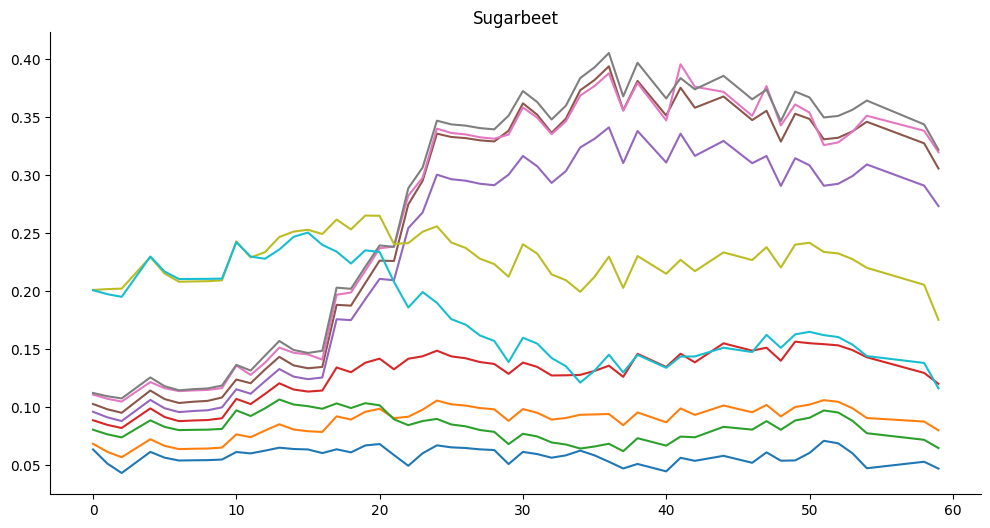

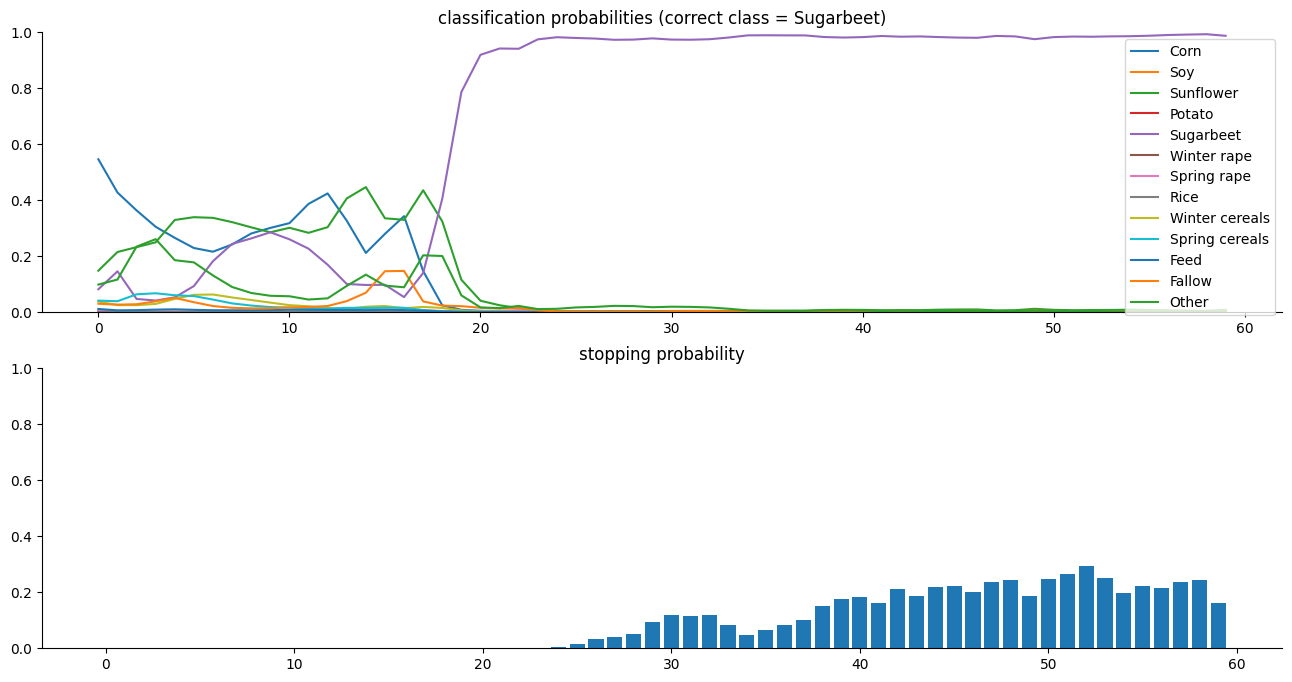

In [25]:
plot_early_nn_predictions(ds, earlyrnn_model, 10, 60)

In [20]:
with open(dumps_path / "earlytempcnn_results.dump", "rb") as f:
    earlytempcnn_results = pickle.load(f)
    earlytempcnn_model = earlytempcnn_results["best_model"]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


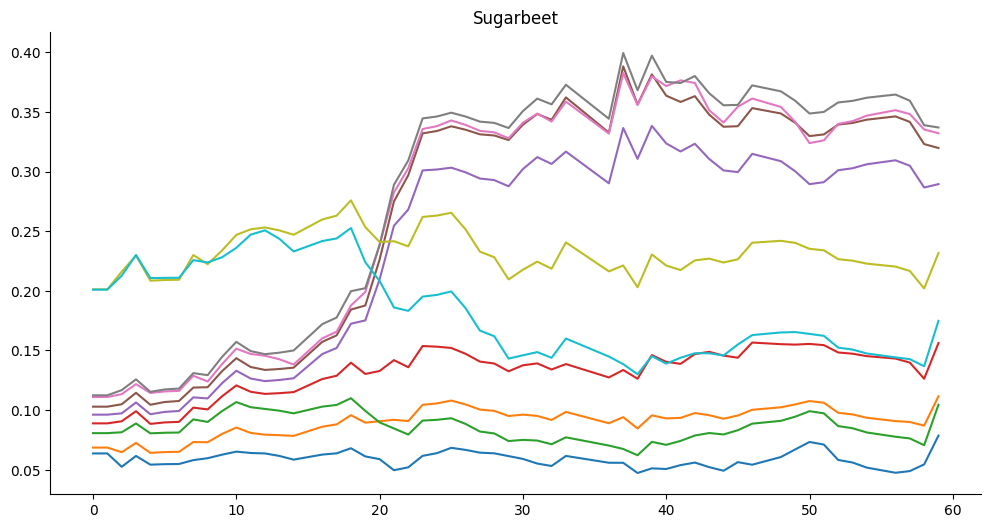

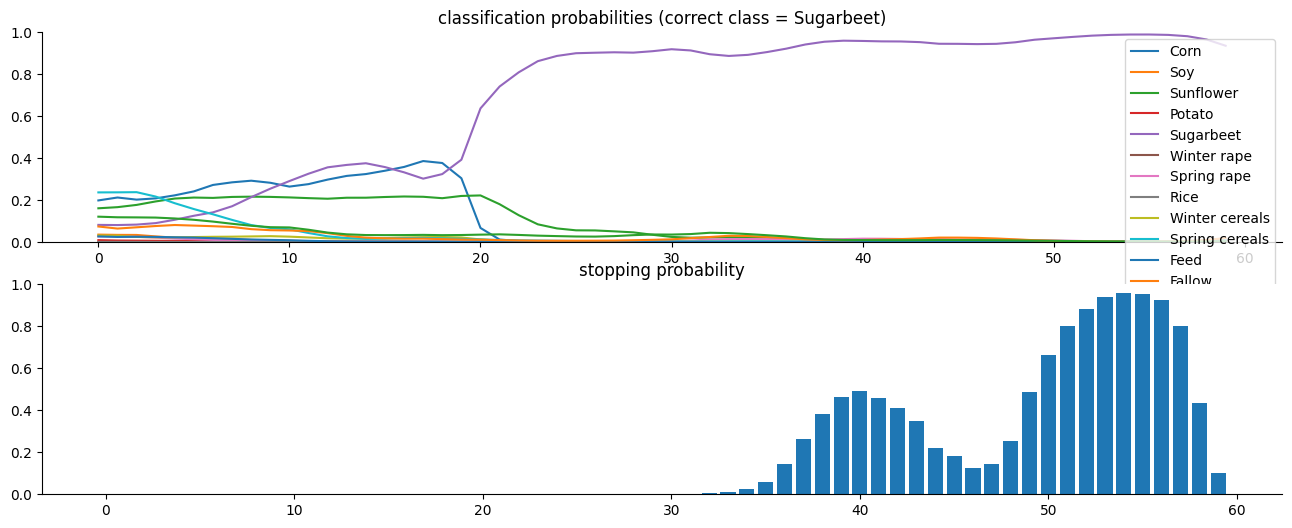

In [21]:
plot_early_nn_predictions(ds, earlytempcnn_model, 10, 60)

In [ ]:
with open(dumps_path / "tempcnn_results.dump", "rb") as f:
    tempcnn_results = pickle.load(f)

tcn_models = [r["best_model"] for r in tempcnn_results.values()]

X[None, :20]

tcn_preds = [tcn_models[i-1](X[None, :i*10]).exp().detach().numpy() for i in range(1, 7)]

pd.DataFrame(np.concatenate(tcn_preds)).plot()

In [ ]:
def plot_monthly_nn_predictions(dataset, models, index, n_months):
    preds = []
    

# Part 4. Robustness check